In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!pip install ipython-autotime

#%load_ext autotime

In [4]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [5]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [6]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [7]:
tqdm = partial(tqdm, position=0, leave=True)

In [8]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [9]:
print(len(files_all))

297


In [10]:
from multiprocessing import Pool

In [11]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [12]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:29<00:00,  1.49s/it]


In [13]:
Dataset = 'Small Village Dataset'

In [14]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 2.9278502464294434 [s] ... size 708.480038 MB


In [15]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 4.474348306655884 [s] ... size 944.639368 MB


In [16]:
del images_left_bgr,images_right_bgr

In [17]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [18]:
from timeit import default_timer as timer

In [19]:
time_all = []

In [20]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


BRISK

In [21]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


In [22]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 378149.12it/s]


In [23]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [24]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [25]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [26]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [27]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [28]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [29]:
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


In [30]:
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 160342.94it/s]


In [31]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [32]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [33]:
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [34]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [35]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [36]:
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [37]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:16<00:00,  6.27s/it]


In [38]:
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 315756.89it/s]


In [39]:
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [40]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [41]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [42]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [43]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [44]:
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [45]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [46]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [47]:
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 145341.17it/s]


In [48]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [49]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [50]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [51]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [52]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [53]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [54]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:09<00:00,  6.28it/s]


In [55]:
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95596.67it/s]


In [56]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [57]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [58]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [59]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [60]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [61]:
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [62]:
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


In [63]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 19584.30it/s]


In [64]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [65]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [66]:
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [67]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [68]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [69]:
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [70]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:25<00:00,  3.42s/it]


In [71]:
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 262007.54it/s]


In [72]:
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [73]:
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [74]:
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [75]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [76]:
del Fdb, all_feat_agast_left

In [77]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [78]:
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:
'''
print(len(left_files_path))

In [ ]:
'''
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:
'''
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [79]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [80]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:08<00:00,  2.14s/it]


In [81]:
for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 49388.33it/s]


In [82]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [83]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [84]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [85]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [86]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [87]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [88]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [89]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [90]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [91]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [92]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [93]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [94]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:20,  2.34s/it]


Number of matches 23362
Number of matches After Lowe's Ratio 339
Number of Robust matches 134




  3%|▎         | 2/61 [00:04<02:21,  2.40s/it]


Number of matches 23772
Number of matches After Lowe's Ratio 414
Number of Robust matches 202




  5%|▍         | 3/61 [00:07<02:19,  2.40s/it]


Number of matches 20529
Number of matches After Lowe's Ratio 373
Number of Robust matches 159




  7%|▋         | 4/61 [00:09<02:07,  2.24s/it]


Number of matches 20226
Number of matches After Lowe's Ratio 482
Number of Robust matches 321




  8%|▊         | 5/61 [00:11<02:02,  2.19s/it]


Number of matches 20276
Number of matches After Lowe's Ratio 280
Number of Robust matches 157




 10%|▉         | 6/61 [00:13<02:00,  2.19s/it]


Number of matches 22532
Number of matches After Lowe's Ratio 649
Number of Robust matches 507




 11%|█▏        | 7/61 [00:15<02:00,  2.23s/it]


Number of matches 21759
Number of matches After Lowe's Ratio 705
Number of Robust matches 518




 13%|█▎        | 8/61 [00:17<01:57,  2.22s/it]


Number of matches 19261
Number of matches After Lowe's Ratio 496
Number of Robust matches 287




 15%|█▍        | 9/61 [00:20<01:57,  2.25s/it]


Number of matches 21274
Number of matches After Lowe's Ratio 499
Number of Robust matches 337




 16%|█▋        | 10/61 [00:22<01:55,  2.26s/it]


Number of matches 22411
Number of matches After Lowe's Ratio 443
Number of Robust matches 269




 18%|█▊        | 11/61 [00:24<01:54,  2.29s/it]


Number of matches 21614
Number of matches After Lowe's Ratio 390
Number of Robust matches 141




 20%|█▉        | 12/61 [00:27<01:52,  2.29s/it]


Number of matches 21161
Number of matches After Lowe's Ratio 366
Number of Robust matches 109




 21%|██▏       | 13/61 [00:29<01:52,  2.35s/it]


Number of matches 29227
Number of matches After Lowe's Ratio 109
Number of Robust matches 46




 23%|██▎       | 14/61 [00:33<02:10,  2.78s/it]


Number of matches 42924
Number of matches After Lowe's Ratio 65
Number of Robust matches 43




 25%|██▍       | 15/61 [00:37<02:31,  3.30s/it]


Number of matches 24645
Number of matches After Lowe's Ratio 164
Number of Robust matches 89




 26%|██▌       | 16/61 [00:40<02:12,  2.95s/it]


Number of matches 19933
Number of matches After Lowe's Ratio 343
Number of Robust matches 142




 28%|██▊       | 17/61 [00:42<01:58,  2.70s/it]


Number of matches 21057
Number of matches After Lowe's Ratio 321
Number of Robust matches 142




 30%|██▉       | 18/61 [00:44<01:47,  2.49s/it]


Number of matches 24507
Number of matches After Lowe's Ratio 295
Number of Robust matches 89




 31%|███       | 19/61 [00:46<01:41,  2.42s/it]


Number of matches 21769
Number of matches After Lowe's Ratio 237
Number of Robust matches 100




 33%|███▎      | 20/61 [00:48<01:35,  2.33s/it]


Number of matches 22982
Number of matches After Lowe's Ratio 196
Number of Robust matches 86




 34%|███▍      | 21/61 [00:51<01:35,  2.38s/it]


Number of matches 23768
Number of matches After Lowe's Ratio 372
Number of Robust matches 239




 36%|███▌      | 22/61 [00:53<01:33,  2.40s/it]


Number of matches 28262
Number of matches After Lowe's Ratio 492
Number of Robust matches 351




 38%|███▊      | 23/61 [00:56<01:34,  2.47s/it]


Number of matches 21439
Number of matches After Lowe's Ratio 375
Number of Robust matches 301




 39%|███▉      | 24/61 [00:58<01:24,  2.29s/it]


Number of matches 18334
Number of matches After Lowe's Ratio 183
Number of Robust matches 86




 41%|████      | 25/61 [00:59<01:17,  2.17s/it]


Number of matches 18808
Number of matches After Lowe's Ratio 189
Number of Robust matches 91




 43%|████▎     | 26/61 [01:01<01:11,  2.04s/it]


Number of matches 22324
Number of matches After Lowe's Ratio 134
Number of Robust matches 55




 44%|████▍     | 27/61 [01:03<01:10,  2.08s/it]


Number of matches 21698
Number of matches After Lowe's Ratio 324
Number of Robust matches 114




 46%|████▌     | 28/61 [01:05<01:09,  2.10s/it]


Number of matches 23810
Number of matches After Lowe's Ratio 141
Number of Robust matches 55




 48%|████▊     | 29/61 [01:09<01:16,  2.39s/it]


Number of matches 36286
Number of matches After Lowe's Ratio 83
Number of Robust matches 39




 49%|████▉     | 30/61 [01:13<01:29,  2.90s/it]


Number of matches 27657
Number of matches After Lowe's Ratio 110
Number of Robust matches 60




 51%|█████     | 31/61 [01:15<01:25,  2.85s/it]


Number of matches 21101
Number of matches After Lowe's Ratio 156
Number of Robust matches 50




 52%|█████▏    | 32/61 [01:17<01:14,  2.58s/it]


Number of matches 16364
Number of matches After Lowe's Ratio 287
Number of Robust matches 105




 54%|█████▍    | 33/61 [01:19<01:04,  2.29s/it]


Number of matches 17594
Number of matches After Lowe's Ratio 284
Number of Robust matches 107




 56%|█████▌    | 34/61 [01:21<00:56,  2.09s/it]


Number of matches 17284
Number of matches After Lowe's Ratio 217
Number of Robust matches 86




 57%|█████▋    | 35/61 [01:22<00:50,  1.95s/it]


Number of matches 18551
Number of matches After Lowe's Ratio 225
Number of Robust matches 110




 59%|█████▉    | 36/61 [01:24<00:47,  1.91s/it]


Number of matches 22945
Number of matches After Lowe's Ratio 300
Number of Robust matches 225




 61%|██████    | 37/61 [01:26<00:49,  2.08s/it]


Number of matches 27055
Number of matches After Lowe's Ratio 327
Number of Robust matches 210




 62%|██████▏   | 38/61 [01:29<00:53,  2.31s/it]


Number of matches 18460
Number of matches After Lowe's Ratio 410
Number of Robust matches 310




 64%|██████▍   | 39/61 [01:31<00:46,  2.10s/it]


Number of matches 14294
Number of matches After Lowe's Ratio 241
Number of Robust matches 174




 66%|██████▌   | 40/61 [01:32<00:37,  1.77s/it]


Number of matches 9266
Number of matches After Lowe's Ratio 137
Number of Robust matches 85




 67%|██████▋   | 41/61 [01:33<00:29,  1.45s/it]


Number of matches 12189
Number of matches After Lowe's Ratio 176
Number of Robust matches 81




 69%|██████▉   | 42/61 [01:34<00:25,  1.32s/it]


Number of matches 15822
Number of matches After Lowe's Ratio 258
Number of Robust matches 104




 70%|███████   | 43/61 [01:35<00:24,  1.35s/it]


Number of matches 22856
Number of matches After Lowe's Ratio 166
Number of Robust matches 56




 72%|███████▏  | 44/61 [01:38<00:31,  1.85s/it]


Number of matches 33250
Number of matches After Lowe's Ratio 54
Number of Robust matches 26




 74%|███████▍  | 45/61 [01:43<00:42,  2.68s/it]


Number of matches 48322
Number of matches After Lowe's Ratio 70
Number of Robust matches 43




 75%|███████▌  | 46/61 [01:49<00:56,  3.76s/it]


Number of matches 31149
Number of matches After Lowe's Ratio 65
Number of Robust matches 44




 77%|███████▋  | 47/61 [01:52<00:49,  3.53s/it]


Number of matches 19883
Number of matches After Lowe's Ratio 87
Number of Robust matches 53




 79%|███████▊  | 48/61 [01:54<00:38,  2.98s/it]


Number of matches 16022
Number of matches After Lowe's Ratio 106
Number of Robust matches 39




 80%|████████  | 49/61 [01:55<00:29,  2.43s/it]


Number of matches 9922
Number of matches After Lowe's Ratio 183
Number of Robust matches 67




 82%|████████▏ | 50/61 [01:56<00:21,  1.93s/it]


Number of matches 12508
Number of matches After Lowe's Ratio 136
Number of Robust matches 62




 84%|████████▎ | 51/61 [01:57<00:16,  1.64s/it]


Number of matches 16045
Number of matches After Lowe's Ratio 127
Number of Robust matches 104




 85%|████████▌ | 52/61 [01:58<00:14,  1.64s/it]


Number of matches 22498
Number of matches After Lowe's Ratio 258
Number of Robust matches 192




 87%|████████▋ | 53/61 [02:01<00:15,  1.98s/it]


Number of matches 27537
Number of matches After Lowe's Ratio 294
Number of Robust matches 204




 89%|████████▊ | 54/61 [02:04<00:15,  2.24s/it]


Number of matches 26008
Number of matches After Lowe's Ratio 324
Number of Robust matches 233




 90%|█████████ | 55/61 [02:06<00:13,  2.31s/it]


Number of matches 18498
Number of matches After Lowe's Ratio 134
Number of Robust matches 91




 92%|█████████▏| 56/61 [02:08<00:11,  2.25s/it]


Number of matches 14864
Number of matches After Lowe's Ratio 83
Number of Robust matches 60




 93%|█████████▎| 57/61 [02:10<00:07,  1.91s/it]


Number of matches 13916
Number of matches After Lowe's Ratio 99
Number of Robust matches 51




 95%|█████████▌| 58/61 [02:11<00:04,  1.65s/it]


Number of matches 12079
Number of matches After Lowe's Ratio 117
Number of Robust matches 42




 97%|█████████▋| 59/61 [02:12<00:02,  1.48s/it]


Number of matches 22714
Number of matches After Lowe's Ratio 84
Number of Robust matches 35




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 33432
Number of matches After Lowe's Ratio 66
Number of Robust matches 38




  2%|▏         | 1/60 [00:02<02:35,  2.64s/it]


Number of matches 23671
Number of matches After Lowe's Ratio 205
Number of Robust matches 79




  3%|▎         | 2/60 [00:05<02:35,  2.68s/it]


Number of matches 31126
Number of matches After Lowe's Ratio 132
Number of Robust matches 50




  5%|▌         | 3/60 [00:08<02:42,  2.85s/it]


Number of matches 22478
Number of matches After Lowe's Ratio 72
Number of Robust matches 30




  7%|▋         | 4/60 [00:11<02:41,  2.88s/it]


Number of matches 21734
Number of matches After Lowe's Ratio 191
Number of Robust matches 90




  8%|▊         | 5/60 [00:14<02:33,  2.80s/it]


Number of matches 22994
Number of matches After Lowe's Ratio 373
Number of Robust matches 165




 10%|█         | 6/60 [00:17<02:32,  2.81s/it]


Number of matches 23656
Number of matches After Lowe's Ratio 332
Number of Robust matches 154




 12%|█▏        | 7/60 [00:19<02:27,  2.79s/it]


Number of matches 21254
Number of matches After Lowe's Ratio 507
Number of Robust matches 287




 13%|█▎        | 8/60 [00:22<02:18,  2.66s/it]


Number of matches 18348
Number of matches After Lowe's Ratio 527
Number of Robust matches 323




 15%|█▌        | 9/60 [00:24<02:07,  2.51s/it]


Number of matches 15386
Number of matches After Lowe's Ratio 571
Number of Robust matches 346




 17%|█▋        | 10/60 [00:25<01:45,  2.12s/it]


Number of matches 14197
Number of matches After Lowe's Ratio 702
Number of Robust matches 540




 18%|█▊        | 11/60 [00:26<01:28,  1.82s/it]


Number of matches 14838
Number of matches After Lowe's Ratio 523
Number of Robust matches 417




 20%|██        | 12/60 [00:27<01:18,  1.64s/it]


Number of matches 20411
Number of matches After Lowe's Ratio 508
Number of Robust matches 408




 22%|██▏       | 13/60 [00:30<01:27,  1.86s/it]


Number of matches 22391
Number of matches After Lowe's Ratio 590
Number of Robust matches 377




 23%|██▎       | 14/60 [00:33<01:40,  2.18s/it]


Number of matches 23990
Number of matches After Lowe's Ratio 559
Number of Robust matches 274




 25%|██▌       | 15/60 [00:35<01:40,  2.23s/it]


Number of matches 23318
Number of matches After Lowe's Ratio 338
Number of Robust matches 177




 27%|██▋       | 16/60 [00:37<01:41,  2.30s/it]


Number of matches 18324
Number of matches After Lowe's Ratio 367
Number of Robust matches 199




 28%|██▊       | 17/60 [00:39<01:34,  2.20s/it]


Number of matches 18227
Number of matches After Lowe's Ratio 204
Number of Robust matches 96




 30%|███       | 18/60 [00:42<01:30,  2.16s/it]


Number of matches 21859
Number of matches After Lowe's Ratio 184
Number of Robust matches 101




 32%|███▏      | 19/60 [00:44<01:32,  2.25s/it]


Number of matches 17217
Number of matches After Lowe's Ratio 71
Number of Robust matches 36




 33%|███▎      | 20/60 [00:46<01:25,  2.14s/it]


Number of matches 17475
Number of matches After Lowe's Ratio 194
Number of Robust matches 89




 35%|███▌      | 21/60 [00:48<01:20,  2.06s/it]


Number of matches 25638
Number of matches After Lowe's Ratio 357
Number of Robust matches 230




 37%|███▋      | 22/60 [00:50<01:25,  2.24s/it]


Number of matches 23870
Number of matches After Lowe's Ratio 375
Number of Robust matches 206




 38%|███▊      | 23/60 [00:53<01:26,  2.33s/it]


Number of matches 20525
Number of matches After Lowe's Ratio 425
Number of Robust matches 208




 40%|████      | 24/60 [00:55<01:22,  2.28s/it]


Number of matches 18552
Number of matches After Lowe's Ratio 626
Number of Robust matches 471




 42%|████▏     | 25/60 [00:57<01:13,  2.11s/it]


Number of matches 13365
Number of matches After Lowe's Ratio 869
Number of Robust matches 746




 43%|████▎     | 26/60 [00:58<00:59,  1.74s/it]


Number of matches 6035
Number of matches After Lowe's Ratio 431
Number of Robust matches 353




 45%|████▌     | 27/60 [00:58<00:45,  1.36s/it]


Number of matches 10355
Number of matches After Lowe's Ratio 301
Number of Robust matches 267




 47%|████▋     | 28/60 [00:59<00:39,  1.22s/it]


Number of matches 21694
Number of matches After Lowe's Ratio 638
Number of Robust matches 551




 48%|████▊     | 29/60 [01:01<00:49,  1.58s/it]


Number of matches 26495
Number of matches After Lowe's Ratio 807
Number of Robust matches 562




 50%|█████     | 30/60 [01:04<00:57,  1.92s/it]


Number of matches 25861
Number of matches After Lowe's Ratio 546
Number of Robust matches 205




 52%|█████▏    | 31/60 [01:07<01:01,  2.12s/it]


Number of matches 25465
Number of matches After Lowe's Ratio 463
Number of Robust matches 206




 53%|█████▎    | 32/60 [01:09<01:01,  2.18s/it]


Number of matches 18312
Number of matches After Lowe's Ratio 325
Number of Robust matches 194




 55%|█████▌    | 33/60 [01:11<00:53,  1.98s/it]


Number of matches 13673
Number of matches After Lowe's Ratio 214
Number of Robust matches 130




 57%|█████▋    | 34/60 [01:12<00:47,  1.82s/it]


Number of matches 23575
Number of matches After Lowe's Ratio 128
Number of Robust matches 89




 58%|█████▊    | 35/60 [01:14<00:47,  1.91s/it]


Number of matches 19006
Number of matches After Lowe's Ratio 78
Number of Robust matches 43




 60%|██████    | 36/60 [01:16<00:44,  1.83s/it]


Number of matches 18650
Number of matches After Lowe's Ratio 168
Number of Robust matches 95




 62%|██████▏   | 37/60 [01:18<00:41,  1.82s/it]


Number of matches 23751
Number of matches After Lowe's Ratio 327
Number of Robust matches 178




 63%|██████▎   | 38/60 [01:20<00:45,  2.08s/it]


Number of matches 26077
Number of matches After Lowe's Ratio 413
Number of Robust matches 179




 65%|██████▌   | 39/60 [01:23<00:46,  2.22s/it]


Number of matches 23680
Number of matches After Lowe's Ratio 482
Number of Robust matches 197




 67%|██████▋   | 40/60 [01:25<00:44,  2.23s/it]


Number of matches 22174
Number of matches After Lowe's Ratio 896
Number of Robust matches 658




 68%|██████▊   | 41/60 [01:27<00:40,  2.13s/it]


Number of matches 15354
Number of matches After Lowe's Ratio 687
Number of Robust matches 647




 70%|███████   | 42/60 [01:28<00:31,  1.77s/it]


Number of matches 1035
Number of matches After Lowe's Ratio 51
Number of Robust matches 43




 72%|███████▏  | 43/60 [01:28<00:22,  1.33s/it]


Number of matches 11668
Number of matches After Lowe's Ratio 85
Number of Robust matches 69




 73%|███████▎  | 44/60 [01:30<00:21,  1.31s/it]


Number of matches 22830
Number of matches After Lowe's Ratio 506
Number of Robust matches 422




 75%|███████▌  | 45/60 [01:32<00:24,  1.62s/it]


Number of matches 27291
Number of matches After Lowe's Ratio 731
Number of Robust matches 528




 77%|███████▋  | 46/60 [01:35<00:27,  1.95s/it]


Number of matches 24606
Number of matches After Lowe's Ratio 394
Number of Robust matches 201




 78%|███████▊  | 47/60 [01:37<00:26,  2.05s/it]


Number of matches 21607
Number of matches After Lowe's Ratio 380
Number of Robust matches 147




 80%|████████  | 48/60 [01:39<00:25,  2.08s/it]


Number of matches 17352
Number of matches After Lowe's Ratio 236
Number of Robust matches 99




 82%|████████▏ | 49/60 [01:40<00:20,  1.86s/it]


Number of matches 11522
Number of matches After Lowe's Ratio 126
Number of Robust matches 102




 83%|████████▎ | 50/60 [01:41<00:15,  1.58s/it]


Number of matches 19508
Number of matches After Lowe's Ratio 182
Number of Robust matches 82




 85%|████████▌ | 51/60 [01:43<00:14,  1.56s/it]


Number of matches 11601
Number of matches After Lowe's Ratio 114
Number of Robust matches 56




 87%|████████▋ | 52/60 [01:44<00:11,  1.39s/it]


Number of matches 18228
Number of matches After Lowe's Ratio 54
Number of Robust matches 23


Number of matches After Lowe's Ratio New 777
Number of Robust matches New 58




 88%|████████▊ | 53/60 [01:46<00:11,  1.58s/it]


Number of matches 21565
Number of matches After Lowe's Ratio 231
Number of Robust matches 97




 90%|█████████ | 54/60 [01:48<00:10,  1.75s/it]


Number of matches 24005
Number of matches After Lowe's Ratio 342
Number of Robust matches 162




 92%|█████████▏| 55/60 [01:50<00:09,  1.93s/it]


Number of matches 22183
Number of matches After Lowe's Ratio 369
Number of Robust matches 186




 93%|█████████▎| 56/60 [01:52<00:07,  1.98s/it]


Number of matches 19913
Number of matches After Lowe's Ratio 664
Number of Robust matches 452




 95%|█████████▌| 57/60 [01:54<00:05,  1.88s/it]


Number of matches 14519
Number of matches After Lowe's Ratio 669
Number of Robust matches 585




 97%|█████████▋| 58/60 [01:55<00:03,  1.60s/it]


Number of matches 6133
Number of matches After Lowe's Ratio 535
Number of Robust matches 507




 98%|█████████▊| 59/60 [01:56<00:01,  1.35s/it]


Number of matches 10384
Number of matches After Lowe's Ratio 429
Number of Robust matches 394




In [95]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005538225173950195 [s] ... size 0.006368 MB


In [96]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005404472351074219 [s] ... size 0.006296 MB


In [97]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:
'''
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [98]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [99]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [100]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:04,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 223
Number of Robust matches 76




  3%|▎         | 2/61 [00:02<01:03,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 273
Number of Robust matches 122




  5%|▍         | 3/61 [00:03<01:02,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 279
Number of Robust matches 98




  7%|▋         | 4/61 [00:04<01:01,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 378
Number of Robust matches 200




  8%|▊         | 5/61 [00:05<01:04,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 202
Number of Robust matches 99




 10%|▉         | 6/61 [00:06<01:01,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 372
Number of Robust matches 264




 11%|█▏        | 7/61 [00:07<00:59,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 402
Number of Robust matches 242




 13%|█▎        | 8/61 [00:08<00:57,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 335
Number of Robust matches 161




 15%|█▍        | 9/61 [00:09<00:56,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 396
Number of Robust matches 239




 16%|█▋        | 10/61 [00:11<00:58,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 346
Number of Robust matches 177




 18%|█▊        | 11/61 [00:12<00:56,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 259
Number of Robust matches 69




 20%|█▉        | 12/61 [00:13<00:55,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 267
Number of Robust matches 73




 21%|██▏       | 13/61 [00:14<00:55,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 141
Number of Robust matches 22


Number of matches After Lowe's Ratio New 1840
Number of Robust matches New 47




 23%|██▎       | 14/61 [00:16<00:59,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 91
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1802
Number of Robust matches New 14




 25%|██▍       | 15/61 [00:17<00:56,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 114
Number of Robust matches 25




 26%|██▌       | 16/61 [00:18<00:53,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 231
Number of Robust matches 96




 28%|██▊       | 17/61 [00:19<00:50,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 276
Number of Robust matches 73




 30%|██▉       | 18/61 [00:20<00:49,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 254
Number of Robust matches 64




 31%|███       | 19/61 [00:21<00:51,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 227
Number of Robust matches 65




 33%|███▎      | 20/61 [00:23<00:48,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 187
Number of Robust matches 52




 34%|███▍      | 21/61 [00:24<00:45,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 232
Number of Robust matches 117




 36%|███▌      | 22/61 [00:25<00:44,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 364
Number of Robust matches 217




 38%|███▊      | 23/61 [00:26<00:42,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 323
Number of Robust matches 194




 39%|███▉      | 24/61 [00:27<00:44,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 218
Number of Robust matches 57




 41%|████      | 25/61 [00:28<00:42,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 228
Number of Robust matches 65




 43%|████▎     | 26/61 [00:30<00:41,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 166
Number of Robust matches 33




 44%|████▍     | 27/61 [00:31<00:39,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 267
Number of Robust matches 72




 46%|████▌     | 28/61 [00:32<00:41,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 148
Number of Robust matches 38




 48%|████▊     | 29/61 [00:33<00:40,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 98
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1711
Number of Robust matches New 9




 49%|████▉     | 30/61 [00:35<00:38,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 92
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1805
Number of Robust matches New 8




 51%|█████     | 31/61 [00:36<00:36,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 171
Number of Robust matches 47




 52%|█████▏    | 32/61 [00:37<00:34,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 275
Number of Robust matches 83




 54%|█████▍    | 33/61 [00:38<00:34,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 283
Number of Robust matches 86




 56%|█████▌    | 34/61 [00:39<00:32,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 259
Number of Robust matches 94




 57%|█████▋    | 35/61 [00:40<00:30,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 235
Number of Robust matches 78




 59%|█████▉    | 36/61 [00:41<00:28,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 265
Number of Robust matches 120




 61%|██████    | 37/61 [00:43<00:28,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 264
Number of Robust matches 121




 62%|██████▏   | 38/61 [00:44<00:29,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 323
Number of Robust matches 216




 64%|██████▍   | 39/61 [00:45<00:26,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 300
Number of Robust matches 131




 66%|██████▌   | 40/61 [00:46<00:24,  1.19s/it]


Number of matches 19879
Number of matches After Lowe's Ratio 233
Number of Robust matches 90




 67%|██████▋   | 41/61 [00:48<00:23,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 230
Number of Robust matches 87




 69%|██████▉   | 42/61 [00:49<00:21,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 274
Number of Robust matches 99




 70%|███████   | 43/61 [00:50<00:22,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 169
Number of Robust matches 55




 72%|███████▏  | 44/61 [00:51<00:21,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 115
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1714
Number of Robust matches New 9




 74%|███████▍  | 45/61 [00:53<00:20,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 82
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1748
Number of Robust matches New 7




 75%|███████▌  | 46/61 [00:54<00:18,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 82
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1726
Number of Robust matches New 7




 77%|███████▋  | 47/61 [00:56<00:18,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 105
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1879
Number of Robust matches New 11




 79%|███████▊  | 48/61 [00:57<00:16,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 174
Number of Robust matches 37




 80%|████████  | 49/61 [00:58<00:14,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 297
Number of Robust matches 78




 82%|████████▏ | 50/61 [00:59<00:13,  1.20s/it]


Number of matches 19734
Number of matches After Lowe's Ratio 220
Number of Robust matches 79




 84%|████████▎ | 51/61 [01:00<00:11,  1.17s/it]


Number of matches 19679
Number of matches After Lowe's Ratio 228
Number of Robust matches 137




 85%|████████▌ | 52/61 [01:01<00:11,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 230
Number of Robust matches 121




 87%|████████▋ | 53/61 [01:02<00:09,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 333
Number of Robust matches 187




 89%|████████▊ | 54/61 [01:04<00:08,  1.16s/it]


Number of matches 19650
Number of matches After Lowe's Ratio 343
Number of Robust matches 249




 90%|█████████ | 55/61 [01:05<00:06,  1.14s/it]


Number of matches 18985
Number of matches After Lowe's Ratio 162
Number of Robust matches 86




 92%|█████████▏| 56/61 [01:06<00:05,  1.12s/it]


Number of matches 19106
Number of matches After Lowe's Ratio 166
Number of Robust matches 96




 93%|█████████▎| 57/61 [01:07<00:04,  1.19s/it]


Number of matches 19878
Number of matches After Lowe's Ratio 159
Number of Robust matches 48




 95%|█████████▌| 58/61 [01:08<00:03,  1.17s/it]


Number of matches 19988
Number of matches After Lowe's Ratio 202
Number of Robust matches 64




 97%|█████████▋| 59/61 [01:09<00:02,  1.16s/it]


Number of matches 19863
Number of matches After Lowe's Ratio 134
Number of Robust matches 35




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 95
Number of Robust matches 25




  2%|▏         | 1/60 [00:01<01:23,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 187
Number of Robust matches 61




  3%|▎         | 2/60 [00:02<01:17,  1.33s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 129
Number of Robust matches 29




  5%|▌         | 3/60 [00:03<01:14,  1.31s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 109
Number of Robust matches 17


Number of matches After Lowe's Ratio New 1761
Number of Robust matches New 8




  7%|▋         | 4/60 [00:04<01:10,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 159
Number of Robust matches 38




  8%|▊         | 5/60 [00:06<01:07,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 280
Number of Robust matches 121




 10%|█         | 6/60 [00:07<01:08,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 269
Number of Robust matches 114




 12%|█▏        | 7/60 [00:08<01:04,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 323
Number of Robust matches 140




 13%|█▎        | 8/60 [00:09<01:02,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 403
Number of Robust matches 232




 15%|█▌        | 9/60 [00:10<01:00,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 403
Number of Robust matches 229




 17%|█▋        | 10/60 [00:12<00:58,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 415
Number of Robust matches 304




 18%|█▊        | 11/60 [00:13<01:00,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 522
Number of Robust matches 315




 20%|██        | 12/60 [00:14<00:58,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 284
Number of Robust matches 148




 22%|██▏       | 13/60 [00:15<00:55,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 382
Number of Robust matches 206




 23%|██▎       | 14/60 [00:16<00:53,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 345
Number of Robust matches 178




 25%|██▌       | 15/60 [00:17<00:51,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 238
Number of Robust matches 90




 27%|██▋       | 16/60 [00:19<00:53,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 277
Number of Robust matches 119




 28%|██▊       | 17/60 [00:20<00:51,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 151
Number of Robust matches 59




 30%|███       | 18/60 [00:21<00:49,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 140
Number of Robust matches 47




 32%|███▏      | 19/60 [00:22<00:49,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 137
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1907
Number of Robust matches New 10




 33%|███▎      | 20/60 [00:24<00:50,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 201
Number of Robust matches 71




 35%|███▌      | 21/60 [00:25<00:47,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 237
Number of Robust matches 90




 37%|███▋      | 22/60 [00:26<00:45,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 270
Number of Robust matches 102




 38%|███▊      | 23/60 [00:27<00:43,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 282
Number of Robust matches 140




 40%|████      | 24/60 [00:28<00:41,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 382
Number of Robust matches 208




 42%|████▏     | 25/60 [00:30<00:43,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 458
Number of Robust matches 315




 43%|████▎     | 26/60 [00:31<00:40,  1.20s/it]


Number of matches 19921
Number of matches After Lowe's Ratio 431
Number of Robust matches 342




 45%|████▌     | 27/60 [00:32<00:38,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 466
Number of Robust matches 342




 47%|████▋     | 28/60 [00:33<00:36,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 304
Number of Robust matches 200




 48%|████▊     | 29/60 [00:34<00:35,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 287
Number of Robust matches 139




 50%|█████     | 30/60 [00:36<00:36,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 334
Number of Robust matches 136




 52%|█████▏    | 31/60 [00:37<00:34,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 257
Number of Robust matches 98




 53%|█████▎    | 32/60 [00:38<00:32,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 242
Number of Robust matches 98




 55%|█████▌    | 33/60 [00:39<00:31,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 264
Number of Robust matches 127




 57%|█████▋    | 34/60 [00:40<00:31,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 155
Number of Robust matches 66




 58%|█████▊    | 35/60 [00:41<00:29,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 116
Number of Robust matches 33




 60%|██████    | 36/60 [00:42<00:27,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 200
Number of Robust matches 72




 62%|██████▏   | 37/60 [00:44<00:26,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 245
Number of Robust matches 102




 63%|██████▎   | 38/60 [00:45<00:24,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 233
Number of Robust matches 80




 65%|██████▌   | 39/60 [00:46<00:25,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 293
Number of Robust matches 117




 67%|██████▋   | 40/60 [00:47<00:23,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 381
Number of Robust matches 207




 68%|██████▊   | 41/60 [00:48<00:21,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 263
Number of Robust matches 198




 70%|███████   | 42/60 [00:49<00:20,  1.11s/it]


Number of matches 15729
Number of matches After Lowe's Ratio 219
Number of Robust matches 110




 72%|███████▏  | 43/60 [00:50<00:17,  1.00s/it]


Number of matches 19971
Number of matches After Lowe's Ratio 170
Number of Robust matches 110




 73%|███████▎  | 44/60 [00:51<00:17,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 238
Number of Robust matches 149




 75%|███████▌  | 45/60 [00:52<00:16,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 296
Number of Robust matches 166




 77%|███████▋  | 46/60 [00:54<00:15,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 262
Number of Robust matches 106




 78%|███████▊  | 47/60 [00:55<00:14,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 223
Number of Robust matches 85




 80%|████████  | 48/60 [00:56<00:13,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 222
Number of Robust matches 75




 82%|████████▏ | 49/60 [00:57<00:13,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 190
Number of Robust matches 105




 83%|████████▎ | 50/60 [00:58<00:11,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 211
Number of Robust matches 90




 85%|████████▌ | 51/60 [00:59<00:10,  1.15s/it]


Number of matches 19800
Number of matches After Lowe's Ratio 185
Number of Robust matches 68




 87%|████████▋ | 52/60 [01:01<00:09,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 132
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1979
Number of Robust matches New 10




 88%|████████▊ | 53/60 [01:02<00:08,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 219
Number of Robust matches 58




 90%|█████████ | 54/60 [01:03<00:07,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 256
Number of Robust matches 78




 92%|█████████▏| 55/60 [01:04<00:05,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 272
Number of Robust matches 121




 93%|█████████▎| 56/60 [01:05<00:04,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 281
Number of Robust matches 153




 95%|█████████▌| 57/60 [01:06<00:03,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 331
Number of Robust matches 259




 97%|█████████▋| 58/60 [01:08<00:02,  1.20s/it]


Number of matches 18794
Number of matches After Lowe's Ratio 368
Number of Robust matches 303




 98%|█████████▊| 59/60 [01:09<00:01,  1.16s/it]


Number of matches 19994
Number of matches After Lowe's Ratio 345
Number of Robust matches 220




In [101]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004562854766845703 [s] ... size 0.006368 MB


In [102]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004209756851196289 [s] ... size 0.006296 MB


In [103]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [104]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [105]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [106]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:13,  1.23s/it]


Number of matches 17643
Number of matches After Lowe's Ratio 2399
Number of Robust matches 1192




  3%|▎         | 2/61 [00:03<01:25,  1.45s/it]


Number of matches 18035
Number of matches After Lowe's Ratio 3472
Number of Robust matches 1926




  5%|▍         | 3/61 [00:04<01:27,  1.50s/it]


Number of matches 17134
Number of matches After Lowe's Ratio 3026
Number of Robust matches 1546




  7%|▋         | 4/61 [00:06<01:27,  1.53s/it]


Number of matches 16168
Number of matches After Lowe's Ratio 3589
Number of Robust matches 2073




  8%|▊         | 5/61 [00:07<01:22,  1.46s/it]


Number of matches 13581
Number of matches After Lowe's Ratio 2146
Number of Robust matches 1339




 10%|▉         | 6/61 [00:08<01:14,  1.35s/it]


Number of matches 11448
Number of matches After Lowe's Ratio 3529
Number of Robust matches 3054



Number of matches 13712
Number of matches After Lowe's Ratio 3432


 11%|█▏        | 7/61 [00:09<01:09,  1.29s/it]

Number of Robust matches 2252




 13%|█▎        | 8/61 [00:11<01:06,  1.25s/it]


Number of matches 14507
Number of matches After Lowe's Ratio 3176
Number of Robust matches 2128




 15%|█▍        | 9/61 [00:12<01:03,  1.23s/it]


Number of matches 16589
Number of matches After Lowe's Ratio 3485
Number of Robust matches 2046




 16%|█▋        | 10/61 [00:13<01:07,  1.32s/it]


Number of matches 17964
Number of matches After Lowe's Ratio 3511
Number of Robust matches 2124




 18%|█▊        | 11/61 [00:15<01:12,  1.45s/it]


Number of matches 17177
Number of matches After Lowe's Ratio 2998
Number of Robust matches 1174




 20%|█▉        | 12/61 [00:17<01:13,  1.51s/it]


Number of matches 16442
Number of matches After Lowe's Ratio 2946
Number of Robust matches 1023




 21%|██▏       | 13/61 [00:18<01:14,  1.55s/it]


Number of matches 13994
Number of matches After Lowe's Ratio 1098
Number of Robust matches 417




 23%|██▎       | 14/61 [00:20<01:08,  1.45s/it]


Number of matches 15036
Number of matches After Lowe's Ratio 966
Number of Robust matches 622




 25%|██▍       | 15/61 [00:21<01:03,  1.37s/it]


Number of matches 13517
Number of matches After Lowe's Ratio 1100
Number of Robust matches 690




 26%|██▌       | 16/61 [00:22<00:58,  1.29s/it]


Number of matches 13560
Number of matches After Lowe's Ratio 2217
Number of Robust matches 973




 28%|██▊       | 17/61 [00:23<00:54,  1.24s/it]


Number of matches 15688
Number of matches After Lowe's Ratio 2425
Number of Robust matches 1204




 30%|██▉       | 18/61 [00:24<00:54,  1.26s/it]


Number of matches 17226
Number of matches After Lowe's Ratio 2541
Number of Robust matches 1066




 31%|███       | 19/61 [00:26<00:59,  1.42s/it]


Number of matches 17022
Number of matches After Lowe's Ratio 2345
Number of Robust matches 1096




 33%|███▎      | 20/61 [00:28<00:59,  1.46s/it]


Number of matches 15991
Number of matches After Lowe's Ratio 1931
Number of Robust matches 885




 34%|███▍      | 21/61 [00:29<00:56,  1.41s/it]


Number of matches 13717
Number of matches After Lowe's Ratio 2903
Number of Robust matches 1929




 36%|███▌      | 22/61 [00:30<00:51,  1.32s/it]


Number of matches 12834
Number of matches After Lowe's Ratio 3835
Number of Robust matches 2875




 38%|███▊      | 23/61 [00:31<00:46,  1.23s/it]


Number of matches 12030
Number of matches After Lowe's Ratio 2906
Number of Robust matches 2497




 39%|███▉      | 24/61 [00:32<00:42,  1.16s/it]


Number of matches 13959
Number of matches After Lowe's Ratio 1492
Number of Robust matches 779




 41%|████      | 25/61 [00:33<00:43,  1.20s/it]


Number of matches 14093
Number of matches After Lowe's Ratio 1797
Number of Robust matches 966




 43%|████▎     | 26/61 [00:34<00:41,  1.18s/it]


Number of matches 15117
Number of matches After Lowe's Ratio 1213
Number of Robust matches 460




 44%|████▍     | 27/61 [00:36<00:40,  1.18s/it]


Number of matches 14682
Number of matches After Lowe's Ratio 2575
Number of Robust matches 925




 46%|████▌     | 28/61 [00:37<00:39,  1.19s/it]


Number of matches 13120
Number of matches After Lowe's Ratio 1453
Number of Robust matches 654




 48%|████▊     | 29/61 [00:38<00:37,  1.18s/it]


Number of matches 17988
Number of matches After Lowe's Ratio 747
Number of Robust matches 366




 49%|████▉     | 30/61 [00:40<00:39,  1.28s/it]


Number of matches 12508
Number of matches After Lowe's Ratio 722
Number of Robust matches 359




 51%|█████     | 31/61 [00:41<00:37,  1.26s/it]


Number of matches 13614
Number of matches After Lowe's Ratio 1455
Number of Robust matches 659




 52%|█████▏    | 32/61 [00:42<00:35,  1.22s/it]


Number of matches 13634
Number of matches After Lowe's Ratio 2186
Number of Robust matches 844




 54%|█████▍    | 33/61 [00:43<00:33,  1.19s/it]


Number of matches 14252
Number of matches After Lowe's Ratio 2317
Number of Robust matches 961




 56%|█████▌    | 34/61 [00:44<00:31,  1.17s/it]


Number of matches 13473
Number of matches After Lowe's Ratio 2064
Number of Robust matches 1133




 57%|█████▋    | 35/61 [00:45<00:29,  1.14s/it]


Number of matches 12047
Number of matches After Lowe's Ratio 1831
Number of Robust matches 980




 59%|█████▉    | 36/61 [00:46<00:27,  1.08s/it]


Number of matches 12495
Number of matches After Lowe's Ratio 2150
Number of Robust matches 1479




 61%|██████    | 37/61 [00:47<00:25,  1.06s/it]


Number of matches 11614
Number of matches After Lowe's Ratio 2776
Number of Robust matches 2015




 62%|██████▏   | 38/61 [00:48<00:23,  1.01s/it]


Number of matches 8998
Number of matches After Lowe's Ratio 2951
Number of Robust matches 2286




 64%|██████▍   | 39/61 [00:49<00:21,  1.03it/s]


Number of matches 6944
Number of matches After Lowe's Ratio 1616
Number of Robust matches 1133




 66%|██████▌   | 40/61 [00:49<00:17,  1.19it/s]


Number of matches 8312
Number of matches After Lowe's Ratio 963
Number of Robust matches 577




 67%|██████▋   | 41/61 [00:50<00:15,  1.29it/s]


Number of matches 9621
Number of matches After Lowe's Ratio 1253
Number of Robust matches 704




 69%|██████▉   | 42/61 [00:51<00:14,  1.31it/s]


Number of matches 10173
Number of matches After Lowe's Ratio 1594
Number of Robust matches 703




 70%|███████   | 43/61 [00:52<00:13,  1.31it/s]


Number of matches 11300
Number of matches After Lowe's Ratio 1242
Number of Robust matches 461




 72%|███████▏  | 44/61 [00:53<00:13,  1.23it/s]


Number of matches 13839
Number of matches After Lowe's Ratio 472
Number of Robust matches 214




 74%|███████▍  | 45/61 [00:54<00:14,  1.10it/s]


Number of matches 16002
Number of matches After Lowe's Ratio 554
Number of Robust matches 339




 75%|███████▌  | 46/61 [00:55<00:15,  1.03s/it]


Number of matches 11703
Number of matches After Lowe's Ratio 456
Number of Robust matches 277




 77%|███████▋  | 47/61 [00:56<00:13,  1.03it/s]


Number of matches 8958
Number of matches After Lowe's Ratio 483
Number of Robust matches 282




 79%|███████▊  | 48/61 [00:56<00:11,  1.13it/s]


Number of matches 9279
Number of matches After Lowe's Ratio 990
Number of Robust matches 359




 80%|████████  | 49/61 [00:57<00:10,  1.12it/s]


Number of matches 8225
Number of matches After Lowe's Ratio 1487
Number of Robust matches 556




 82%|████████▏ | 50/61 [00:58<00:08,  1.25it/s]


Number of matches 6352
Number of matches After Lowe's Ratio 1028
Number of Robust matches 510




 84%|████████▎ | 51/61 [00:58<00:07,  1.41it/s]


Number of matches 6724
Number of matches After Lowe's Ratio 775
Number of Robust matches 574




 85%|████████▌ | 52/61 [00:59<00:05,  1.52it/s]


Number of matches 9644
Number of matches After Lowe's Ratio 1600
Number of Robust matches 1341




 87%|████████▋ | 53/61 [01:00<00:05,  1.46it/s]


Number of matches 9807
Number of matches After Lowe's Ratio 2843
Number of Robust matches 2584




 89%|████████▊ | 54/61 [01:01<00:04,  1.43it/s]


Number of matches 6855
Number of matches After Lowe's Ratio 2664
Number of Robust matches 1938




 90%|█████████ | 55/61 [01:01<00:03,  1.60it/s]


Number of matches 3435
Number of matches After Lowe's Ratio 1293
Number of Robust matches 1037




 92%|█████████▏| 56/61 [01:01<00:02,  1.93it/s]


Number of matches 4596
Number of matches After Lowe's Ratio 517
Number of Robust matches 390




 93%|█████████▎| 57/61 [01:02<00:01,  2.15it/s]


Number of matches 6012
Number of matches After Lowe's Ratio 631
Number of Robust matches 400




 95%|█████████▌| 58/61 [01:02<00:01,  2.18it/s]


Number of matches 6091
Number of matches After Lowe's Ratio 980
Number of Robust matches 480




 97%|█████████▋| 59/61 [01:02<00:00,  2.20it/s]


Number of matches 4868
Number of matches After Lowe's Ratio 653
Number of Robust matches 311




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 8131
Number of matches After Lowe's Ratio 627
Number of Robust matches 434




  2%|▏         | 1/60 [00:01<01:06,  1.13s/it]


Number of matches 11792
Number of matches After Lowe's Ratio 1959
Number of Robust matches 913




  3%|▎         | 2/60 [00:02<01:02,  1.07s/it]


Number of matches 12226
Number of matches After Lowe's Ratio 1321
Number of Robust matches 605




  5%|▌         | 3/60 [00:03<01:04,  1.12s/it]


Number of matches 12701
Number of matches After Lowe's Ratio 933
Number of Robust matches 390




  7%|▋         | 4/60 [00:04<01:02,  1.11s/it]


Number of matches 15497
Number of matches After Lowe's Ratio 1477
Number of Robust matches 773




  8%|▊         | 5/60 [00:05<01:05,  1.20s/it]


Number of matches 17962
Number of matches After Lowe's Ratio 2957
Number of Robust matches 1555




 10%|█         | 6/60 [00:07<01:13,  1.36s/it]


Number of matches 18614
Number of matches After Lowe's Ratio 2991
Number of Robust matches 1712




 12%|█▏        | 7/60 [00:09<01:17,  1.47s/it]


Number of matches 17275
Number of matches After Lowe's Ratio 3590
Number of Robust matches 1797




 13%|█▎        | 8/60 [00:11<01:21,  1.58s/it]


Number of matches 15683
Number of matches After Lowe's Ratio 3740
Number of Robust matches 2232




 15%|█▌        | 9/60 [00:12<01:15,  1.48s/it]


Number of matches 13151
Number of matches After Lowe's Ratio 3421
Number of Robust matches 1924




 17%|█▋        | 10/60 [00:13<01:06,  1.34s/it]


Number of matches 10207
Number of matches After Lowe's Ratio 2905
Number of Robust matches 2104




 18%|█▊        | 11/60 [00:14<00:58,  1.19s/it]


Number of matches 11405
Number of matches After Lowe's Ratio 2703
Number of Robust matches 2289




 20%|██        | 12/60 [00:15<00:54,  1.13s/it]


Number of matches 15489
Number of matches After Lowe's Ratio 2537
Number of Robust matches 1654




 22%|██▏       | 13/60 [00:16<00:56,  1.20s/it]


Number of matches 17739
Number of matches After Lowe's Ratio 3905
Number of Robust matches 2308




 23%|██▎       | 14/60 [00:18<01:05,  1.43s/it]


Number of matches 19034
Number of matches After Lowe's Ratio 3868
Number of Robust matches 2167




 25%|██▌       | 15/60 [00:20<01:10,  1.56s/it]


Number of matches 18357
Number of matches After Lowe's Ratio 2871
Number of Robust matches 1707




 27%|██▋       | 16/60 [00:22<01:09,  1.59s/it]


Number of matches 14763
Number of matches After Lowe's Ratio 3061
Number of Robust matches 1940




 28%|██▊       | 17/60 [00:23<01:02,  1.45s/it]


Number of matches 10609
Number of matches After Lowe's Ratio 1701
Number of Robust matches 879




 30%|███       | 18/60 [00:23<00:53,  1.27s/it]


Number of matches 11592
Number of matches After Lowe's Ratio 1344
Number of Robust matches 758




 32%|███▏      | 19/60 [00:24<00:47,  1.17s/it]


Number of matches 10500
Number of matches After Lowe's Ratio 731
Number of Robust matches 370




 33%|███▎      | 20/60 [00:26<00:46,  1.15s/it]


Number of matches 14710
Number of matches After Lowe's Ratio 1734
Number of Robust matches 860




 35%|███▌      | 21/60 [00:27<00:46,  1.20s/it]


Number of matches 18340
Number of matches After Lowe's Ratio 3012
Number of Robust matches 1705




 37%|███▋      | 22/60 [00:29<00:52,  1.37s/it]


Number of matches 18113
Number of matches After Lowe's Ratio 3345
Number of Robust matches 1726




 38%|███▊      | 23/60 [00:30<00:54,  1.47s/it]


Number of matches 16298
Number of matches After Lowe's Ratio 3463
Number of Robust matches 1607




 40%|████      | 24/60 [00:32<00:51,  1.44s/it]


Number of matches 13841
Number of matches After Lowe's Ratio 3506
Number of Robust matches 2170




 42%|████▏     | 25/60 [00:33<00:47,  1.36s/it]


Number of matches 10555
Number of matches After Lowe's Ratio 3357
Number of Robust matches 2729




 43%|████▎     | 26/60 [00:34<00:42,  1.26s/it]


Number of matches 6193
Number of matches After Lowe's Ratio 2003
Number of Robust matches 1822




 45%|████▌     | 27/60 [00:34<00:34,  1.03s/it]


Number of matches 8916
Number of matches After Lowe's Ratio 1527
Number of Robust matches 1209




 47%|████▋     | 28/60 [00:35<00:30,  1.04it/s]


Number of matches 14591
Number of matches After Lowe's Ratio 2424
Number of Robust matches 1751




 48%|████▊     | 29/60 [00:37<00:33,  1.07s/it]


Number of matches 17426
Number of matches After Lowe's Ratio 4128
Number of Robust matches 2617




 50%|█████     | 30/60 [00:38<00:38,  1.28s/it]


Number of matches 19392
Number of matches After Lowe's Ratio 4299
Number of Robust matches 2231




 52%|█████▏    | 31/60 [00:40<00:42,  1.46s/it]


Number of matches 17100
Number of matches After Lowe's Ratio 3521
Number of Robust matches 1691




 53%|█████▎    | 32/60 [00:42<00:44,  1.58s/it]


Number of matches 13241
Number of matches After Lowe's Ratio 2885
Number of Robust matches 1497




 55%|█████▌    | 33/60 [00:43<00:37,  1.40s/it]


Number of matches 9080
Number of matches After Lowe's Ratio 2233
Number of Robust matches 1244




 57%|█████▋    | 34/60 [00:44<00:30,  1.19s/it]


Number of matches 8796
Number of matches After Lowe's Ratio 892
Number of Robust matches 687




 58%|█████▊    | 35/60 [00:44<00:25,  1.04s/it]


Number of matches 9693
Number of matches After Lowe's Ratio 836
Number of Robust matches 450




 60%|██████    | 36/60 [00:45<00:23,  1.02it/s]


Number of matches 12802
Number of matches After Lowe's Ratio 1589
Number of Robust matches 1086




 62%|██████▏   | 37/60 [00:46<00:23,  1.02s/it]


Number of matches 16450
Number of matches After Lowe's Ratio 2875
Number of Robust matches 1788




 63%|██████▎   | 38/60 [00:48<00:27,  1.24s/it]


Number of matches 17657
Number of matches After Lowe's Ratio 3311
Number of Robust matches 1538




 65%|██████▌   | 39/60 [00:50<00:30,  1.46s/it]


Number of matches 16476
Number of matches After Lowe's Ratio 3784
Number of Robust matches 1934




 67%|██████▋   | 40/60 [00:52<00:30,  1.51s/it]


Number of matches 13610
Number of matches After Lowe's Ratio 4099
Number of Robust matches 2827




 68%|██████▊   | 41/60 [00:53<00:26,  1.39s/it]


Number of matches 9435
Number of matches After Lowe's Ratio 2912
Number of Robust matches 2508




 70%|███████   | 42/60 [00:53<00:21,  1.17s/it]


Number of matches 3890
Number of matches After Lowe's Ratio 1098
Number of Robust matches 1033




 72%|███████▏  | 43/60 [00:54<00:15,  1.08it/s]


Number of matches 7932
Number of matches After Lowe's Ratio 1063
Number of Robust matches 959




 73%|███████▎  | 44/60 [00:55<00:14,  1.13it/s]


Number of matches 15348
Number of matches After Lowe's Ratio 1897
Number of Robust matches 1522




 75%|███████▌  | 45/60 [00:56<00:15,  1.04s/it]


Number of matches 18003
Number of matches After Lowe's Ratio 4248
Number of Robust matches 2796




 77%|███████▋  | 46/60 [00:58<00:18,  1.35s/it]


Number of matches 18019
Number of matches After Lowe's Ratio 3574
Number of Robust matches 1879




 78%|███████▊  | 47/60 [01:00<00:19,  1.48s/it]


Number of matches 15330
Number of matches After Lowe's Ratio 3060
Number of Robust matches 1434




 80%|████████  | 48/60 [01:01<00:16,  1.38s/it]


Number of matches 9854
Number of matches After Lowe's Ratio 1815
Number of Robust matches 944




 82%|████████▏ | 49/60 [01:02<00:13,  1.19s/it]


Number of matches 6937
Number of matches After Lowe's Ratio 1192
Number of Robust matches 827




 83%|████████▎ | 50/60 [01:02<00:10,  1.00s/it]


Number of matches 8332
Number of matches After Lowe's Ratio 1296
Number of Robust matches 697




 85%|████████▌ | 51/60 [01:03<00:07,  1.14it/s]


Number of matches 7307
Number of matches After Lowe's Ratio 1083
Number of Robust matches 502




 87%|████████▋ | 52/60 [01:04<00:06,  1.26it/s]


Number of matches 10661
Number of matches After Lowe's Ratio 750
Number of Robust matches 483




 88%|████████▊ | 53/60 [01:05<00:06,  1.11it/s]


Number of matches 15656
Number of matches After Lowe's Ratio 1932
Number of Robust matches 850




 90%|█████████ | 54/60 [01:06<00:06,  1.04s/it]


Number of matches 17611
Number of matches After Lowe's Ratio 3243
Number of Robust matches 1525




 92%|█████████▏| 55/60 [01:08<00:06,  1.23s/it]


Number of matches 16504
Number of matches After Lowe's Ratio 3543
Number of Robust matches 1939




 93%|█████████▎| 56/60 [01:09<00:05,  1.33s/it]


Number of matches 13941
Number of matches After Lowe's Ratio 3923
Number of Robust matches 2666




 95%|█████████▌| 57/60 [01:10<00:03,  1.26s/it]


Number of matches 10287
Number of matches After Lowe's Ratio 3262
Number of Robust matches 2920




 97%|█████████▋| 58/60 [01:11<00:02,  1.12s/it]


Number of matches 5336
Number of matches After Lowe's Ratio 2141
Number of Robust matches 1916




 98%|█████████▊| 59/60 [01:12<00:00,  1.08it/s]


Number of matches 7608
Number of matches After Lowe's Ratio 1671
Number of Robust matches 1332




In [107]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0051157474517822266 [s] ... size 0.006368 MB


In [108]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.007517576217651367 [s] ... size 0.006296 MB


In [109]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [110]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [111]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [112]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:00,  1.02s/it]


Number of matches 15572
Number of matches After Lowe's Ratio 891
Number of Robust matches 511




  3%|▎         | 2/61 [00:02<01:02,  1.06s/it]


Number of matches 15565
Number of matches After Lowe's Ratio 1072
Number of Robust matches 557




  5%|▍         | 3/61 [00:03<01:03,  1.10s/it]


Number of matches 14945
Number of matches After Lowe's Ratio 1060
Number of Robust matches 633




  7%|▋         | 4/61 [00:04<01:02,  1.10s/it]


Number of matches 14523
Number of matches After Lowe's Ratio 1298
Number of Robust matches 853




  8%|▊         | 5/61 [00:05<01:00,  1.08s/it]


Number of matches 12967
Number of matches After Lowe's Ratio 763
Number of Robust matches 516




 10%|▉         | 6/61 [00:06<00:56,  1.02s/it]


Number of matches 11221
Number of matches After Lowe's Ratio 1650
Number of Robust matches 1374




 11%|█▏        | 7/61 [00:07<00:55,  1.02s/it]


Number of matches 12384
Number of matches After Lowe's Ratio 1751
Number of Robust matches 1379




 13%|█▎        | 8/61 [00:08<00:52,  1.01it/s]


Number of matches 13393
Number of matches After Lowe's Ratio 1348
Number of Robust matches 923




 15%|█▍        | 9/61 [00:09<00:51,  1.01it/s]


Number of matches 14868
Number of matches After Lowe's Ratio 1363
Number of Robust matches 940




 16%|█▋        | 10/61 [00:10<00:52,  1.03s/it]


Number of matches 15661
Number of matches After Lowe's Ratio 1209
Number of Robust matches 843




 18%|█▊        | 11/61 [00:11<00:53,  1.08s/it]


Number of matches 15325
Number of matches After Lowe's Ratio 946
Number of Robust matches 426




 20%|█▉        | 12/61 [00:12<00:53,  1.10s/it]


Number of matches 14663
Number of matches After Lowe's Ratio 849
Number of Robust matches 340




 21%|██▏       | 13/61 [00:14<00:54,  1.14s/it]


Number of matches 13310
Number of matches After Lowe's Ratio 323
Number of Robust matches 128




 23%|██▎       | 14/61 [00:15<00:51,  1.09s/it]


Number of matches 15192
Number of matches After Lowe's Ratio 207
Number of Robust matches 123




 25%|██▍       | 15/61 [00:16<00:49,  1.09s/it]


Number of matches 12840
Number of matches After Lowe's Ratio 406
Number of Robust matches 282




 26%|██▌       | 16/61 [00:16<00:46,  1.03s/it]


Number of matches 12661
Number of matches After Lowe's Ratio 1000
Number of Robust matches 520




 28%|██▊       | 17/61 [00:17<00:44,  1.00s/it]


Number of matches 14259
Number of matches After Lowe's Ratio 936
Number of Robust matches 524




 30%|██▉       | 18/61 [00:19<00:44,  1.03s/it]


Number of matches 15386
Number of matches After Lowe's Ratio 916
Number of Robust matches 405




 31%|███       | 19/61 [00:20<00:45,  1.07s/it]


Number of matches 15049
Number of matches After Lowe's Ratio 737
Number of Robust matches 347




 33%|███▎      | 20/61 [00:21<00:47,  1.16s/it]


Number of matches 14461
Number of matches After Lowe's Ratio 484
Number of Robust matches 263




 34%|███▍      | 21/61 [00:22<00:44,  1.12s/it]


Number of matches 12879
Number of matches After Lowe's Ratio 1083
Number of Robust matches 819




 36%|███▌      | 22/61 [00:23<00:41,  1.07s/it]


Number of matches 12975
Number of matches After Lowe's Ratio 1868
Number of Robust matches 1419




 38%|███▊      | 23/61 [00:24<00:39,  1.03s/it]


Number of matches 10943
Number of matches After Lowe's Ratio 1406
Number of Robust matches 1099




 39%|███▉      | 24/61 [00:25<00:35,  1.04it/s]


Number of matches 12241
Number of matches After Lowe's Ratio 498
Number of Robust matches 265




 41%|████      | 25/61 [00:26<00:33,  1.07it/s]


Number of matches 12538
Number of matches After Lowe's Ratio 627
Number of Robust matches 395




 43%|████▎     | 26/61 [00:27<00:32,  1.08it/s]


Number of matches 13804
Number of matches After Lowe's Ratio 370
Number of Robust matches 144




 44%|████▍     | 27/61 [00:28<00:34,  1.03s/it]


Number of matches 13307
Number of matches After Lowe's Ratio 709
Number of Robust matches 255




 46%|████▌     | 28/61 [00:29<00:33,  1.00s/it]


Number of matches 12321
Number of matches After Lowe's Ratio 507
Number of Robust matches 219




 48%|████▊     | 29/61 [00:30<00:31,  1.00it/s]


Number of matches 17240
Number of matches After Lowe's Ratio 339
Number of Robust matches 172




 49%|████▉     | 30/61 [00:31<00:34,  1.12s/it]


Number of matches 12165
Number of matches After Lowe's Ratio 376
Number of Robust matches 199




 51%|█████     | 31/61 [00:32<00:31,  1.04s/it]


Number of matches 12313
Number of matches After Lowe's Ratio 657
Number of Robust matches 288




 52%|█████▏    | 32/61 [00:33<00:28,  1.00it/s]


Number of matches 12492
Number of matches After Lowe's Ratio 811
Number of Robust matches 331




 54%|█████▍    | 33/61 [00:34<00:26,  1.04it/s]


Number of matches 12449
Number of matches After Lowe's Ratio 771
Number of Robust matches 401




 56%|█████▌    | 34/61 [00:35<00:25,  1.08it/s]


Number of matches 11478
Number of matches After Lowe's Ratio 635
Number of Robust matches 337




 57%|█████▋    | 35/61 [00:36<00:24,  1.05it/s]


Number of matches 10440
Number of matches After Lowe's Ratio 610
Number of Robust matches 367




 59%|█████▉    | 36/61 [00:36<00:22,  1.12it/s]


Number of matches 11727
Number of matches After Lowe's Ratio 844
Number of Robust matches 673




 61%|██████    | 37/61 [00:37<00:20,  1.14it/s]


Number of matches 12139
Number of matches After Lowe's Ratio 1488
Number of Robust matches 1363




 62%|██████▏   | 38/61 [00:38<00:19,  1.16it/s]


Number of matches 8889
Number of matches After Lowe's Ratio 1563
Number of Robust matches 1226




 64%|██████▍   | 39/61 [00:39<00:16,  1.30it/s]


Number of matches 6581
Number of matches After Lowe's Ratio 701
Number of Robust matches 554




 66%|██████▌   | 40/61 [00:39<00:14,  1.49it/s]


Number of matches 6466
Number of matches After Lowe's Ratio 462
Number of Robust matches 337




 67%|██████▋   | 41/61 [00:40<00:12,  1.64it/s]


Number of matches 8189
Number of matches After Lowe's Ratio 498
Number of Robust matches 293




 69%|██████▉   | 42/61 [00:40<00:11,  1.66it/s]


Number of matches 8769
Number of matches After Lowe's Ratio 548
Number of Robust matches 237




 70%|███████   | 43/61 [00:41<00:10,  1.65it/s]


Number of matches 10277
Number of matches After Lowe's Ratio 400
Number of Robust matches 176




 72%|███████▏  | 44/61 [00:42<00:12,  1.37it/s]


Number of matches 14301
Number of matches After Lowe's Ratio 171
Number of Robust matches 75




 74%|███████▍  | 45/61 [00:43<00:13,  1.19it/s]


Number of matches 17464
Number of matches After Lowe's Ratio 209
Number of Robust matches 118




 75%|███████▌  | 46/61 [00:44<00:15,  1.02s/it]


Number of matches 12362
Number of matches After Lowe's Ratio 211
Number of Robust matches 126




 77%|███████▋  | 47/61 [00:45<00:13,  1.04it/s]


Number of matches 8106
Number of matches After Lowe's Ratio 248
Number of Robust matches 154




 79%|███████▊  | 48/61 [00:46<00:10,  1.20it/s]


Number of matches 7917
Number of matches After Lowe's Ratio 356
Number of Robust matches 167




 80%|████████  | 49/61 [00:46<00:08,  1.34it/s]


Number of matches 7158
Number of matches After Lowe's Ratio 579
Number of Robust matches 246




 82%|████████▏ | 50/61 [00:47<00:07,  1.52it/s]


Number of matches 5203
Number of matches After Lowe's Ratio 474
Number of Robust matches 276




 84%|████████▎ | 51/61 [00:47<00:05,  1.75it/s]


Number of matches 6448
Number of matches After Lowe's Ratio 442
Number of Robust matches 377




 85%|████████▌ | 52/61 [00:47<00:04,  1.85it/s]


Number of matches 9666
Number of matches After Lowe's Ratio 849
Number of Robust matches 738




 87%|████████▋ | 53/61 [00:48<00:04,  1.73it/s]


Number of matches 10576
Number of matches After Lowe's Ratio 1466
Number of Robust matches 1231




 89%|████████▊ | 54/61 [00:49<00:04,  1.64it/s]


Number of matches 7499
Number of matches After Lowe's Ratio 1347
Number of Robust matches 1150




 90%|█████████ | 55/61 [00:49<00:03,  1.61it/s]


Number of matches 4165
Number of matches After Lowe's Ratio 648
Number of Robust matches 508




 92%|█████████▏| 56/61 [00:50<00:02,  1.94it/s]


Number of matches 4071
Number of matches After Lowe's Ratio 236
Number of Robust matches 171




 93%|█████████▎| 57/61 [00:50<00:01,  2.19it/s]


Number of matches 5678
Number of matches After Lowe's Ratio 271
Number of Robust matches 166




 95%|█████████▌| 58/61 [00:50<00:01,  2.30it/s]


Number of matches 6068
Number of matches After Lowe's Ratio 352
Number of Robust matches 186




 97%|█████████▋| 59/61 [00:51<00:00,  2.33it/s]


Number of matches 5873
Number of matches After Lowe's Ratio 258
Number of Robust matches 143




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 10422
Number of matches After Lowe's Ratio 236
Number of Robust matches 140




  2%|▏         | 1/60 [00:00<00:52,  1.12it/s]


Number of matches 10886
Number of matches After Lowe's Ratio 689
Number of Robust matches 367




  3%|▎         | 2/60 [00:01<00:50,  1.15it/s]


Number of matches 12783
Number of matches After Lowe's Ratio 504
Number of Robust matches 276




  5%|▌         | 3/60 [00:02<00:49,  1.14it/s]


Number of matches 11818
Number of matches After Lowe's Ratio 212
Number of Robust matches 89




  7%|▋         | 4/60 [00:03<00:48,  1.15it/s]


Number of matches 14010
Number of matches After Lowe's Ratio 415
Number of Robust matches 202




  8%|▊         | 5/60 [00:04<00:55,  1.00s/it]


Number of matches 16050
Number of matches After Lowe's Ratio 888
Number of Robust matches 503




 10%|█         | 6/60 [00:06<00:58,  1.08s/it]


Number of matches 16288
Number of matches After Lowe's Ratio 847
Number of Robust matches 402




 12%|█▏        | 7/60 [00:07<01:00,  1.13s/it]


Number of matches 15361
Number of matches After Lowe's Ratio 1289
Number of Robust matches 726




 13%|█▎        | 8/60 [00:08<00:58,  1.13s/it]


Number of matches 14108
Number of matches After Lowe's Ratio 1423
Number of Robust matches 984




 15%|█▌        | 9/60 [00:09<00:56,  1.10s/it]


Number of matches 12050
Number of matches After Lowe's Ratio 1394
Number of Robust matches 869




 17%|█▋        | 10/60 [00:10<00:50,  1.02s/it]


Number of matches 9245
Number of matches After Lowe's Ratio 1527
Number of Robust matches 1184




 18%|█▊        | 11/60 [00:10<00:44,  1.10it/s]


Number of matches 10237
Number of matches After Lowe's Ratio 1549
Number of Robust matches 1243




 20%|██        | 12/60 [00:11<00:45,  1.06it/s]


Number of matches 13718
Number of matches After Lowe's Ratio 1320
Number of Robust matches 1028




 22%|██▏       | 13/60 [00:12<00:45,  1.03it/s]


Number of matches 15600
Number of matches After Lowe's Ratio 1543
Number of Robust matches 1114




 23%|██▎       | 14/60 [00:14<00:47,  1.04s/it]


Number of matches 16503
Number of matches After Lowe's Ratio 1342
Number of Robust matches 840




 25%|██▌       | 15/60 [00:15<00:51,  1.14s/it]


Number of matches 16264
Number of matches After Lowe's Ratio 897
Number of Robust matches 540




 27%|██▋       | 16/60 [00:16<00:50,  1.15s/it]


Number of matches 12663
Number of matches After Lowe's Ratio 1013
Number of Robust matches 550




 28%|██▊       | 17/60 [00:17<00:45,  1.07s/it]


Number of matches 9416
Number of matches After Lowe's Ratio 652
Number of Robust matches 400




 30%|███       | 18/60 [00:18<00:39,  1.05it/s]


Number of matches 11501
Number of matches After Lowe's Ratio 671
Number of Robust matches 366




 32%|███▏      | 19/60 [00:19<00:36,  1.11it/s]


Number of matches 9230
Number of matches After Lowe's Ratio 292
Number of Robust matches 151




 33%|███▎      | 20/60 [00:19<00:36,  1.10it/s]


Number of matches 13081
Number of matches After Lowe's Ratio 702
Number of Robust matches 365




 35%|███▌      | 21/60 [00:21<00:36,  1.06it/s]


Number of matches 16665
Number of matches After Lowe's Ratio 980
Number of Robust matches 535




 37%|███▋      | 22/60 [00:22<00:41,  1.09s/it]


Number of matches 16055
Number of matches After Lowe's Ratio 954
Number of Robust matches 531




 38%|███▊      | 23/60 [00:23<00:41,  1.12s/it]


Number of matches 14308
Number of matches After Lowe's Ratio 1046
Number of Robust matches 626




 40%|████      | 24/60 [00:24<00:39,  1.10s/it]


Number of matches 12186
Number of matches After Lowe's Ratio 1466
Number of Robust matches 1101




 42%|████▏     | 25/60 [00:25<00:35,  1.01s/it]


Number of matches 9074
Number of matches After Lowe's Ratio 1770
Number of Robust matches 1124




 43%|████▎     | 26/60 [00:26<00:29,  1.14it/s]


Number of matches 5214
Number of matches After Lowe's Ratio 1251
Number of Robust matches 1120




 45%|████▌     | 27/60 [00:26<00:24,  1.37it/s]


Number of matches 7096
Number of matches After Lowe's Ratio 949
Number of Robust matches 734




 47%|████▋     | 28/60 [00:27<00:23,  1.34it/s]


Number of matches 12768
Number of matches After Lowe's Ratio 1252
Number of Robust matches 984




 48%|████▊     | 29/60 [00:28<00:25,  1.24it/s]


Number of matches 15200
Number of matches After Lowe's Ratio 1470
Number of Robust matches 994




 50%|█████     | 30/60 [00:29<00:27,  1.09it/s]


Number of matches 16833
Number of matches After Lowe's Ratio 1463
Number of Robust matches 741




 52%|█████▏    | 31/60 [00:30<00:31,  1.07s/it]


Number of matches 15263
Number of matches After Lowe's Ratio 1184
Number of Robust matches 742




 53%|█████▎    | 32/60 [00:31<00:30,  1.08s/it]


Number of matches 11580
Number of matches After Lowe's Ratio 1132
Number of Robust matches 764




 55%|█████▌    | 33/60 [00:32<00:27,  1.00s/it]


Number of matches 7901
Number of matches After Lowe's Ratio 959
Number of Robust matches 689




 57%|█████▋    | 34/60 [00:33<00:22,  1.15it/s]


Number of matches 8752
Number of matches After Lowe's Ratio 391
Number of Robust matches 316




 58%|█████▊    | 35/60 [00:33<00:19,  1.27it/s]


Number of matches 9016
Number of matches After Lowe's Ratio 304
Number of Robust matches 195




 60%|██████    | 36/60 [00:34<00:19,  1.22it/s]


Number of matches 11472
Number of matches After Lowe's Ratio 511
Number of Robust matches 381




 62%|██████▏   | 37/60 [00:35<00:19,  1.20it/s]


Number of matches 14917
Number of matches After Lowe's Ratio 1012
Number of Robust matches 657




 63%|██████▎   | 38/60 [00:36<00:20,  1.09it/s]


Number of matches 15913
Number of matches After Lowe's Ratio 837
Number of Robust matches 428




 65%|██████▌   | 39/60 [00:37<00:21,  1.00s/it]


Number of matches 14605
Number of matches After Lowe's Ratio 1172
Number of Robust matches 611




 67%|██████▋   | 40/60 [00:38<00:20,  1.02s/it]


Number of matches 11939
Number of matches After Lowe's Ratio 1692
Number of Robust matches 1466




 68%|██████▊   | 41/60 [00:39<00:17,  1.06it/s]


Number of matches 7822
Number of matches After Lowe's Ratio 1363
Number of Robust matches 1167




 70%|███████   | 42/60 [00:40<00:14,  1.26it/s]


Number of matches 2513
Number of matches After Lowe's Ratio 587
Number of Robust matches 466




 72%|███████▏  | 43/60 [00:40<00:11,  1.53it/s]


Number of matches 6523
Number of matches After Lowe's Ratio 557
Number of Robust matches 367




 73%|███████▎  | 44/60 [00:41<00:10,  1.46it/s]


Number of matches 13467
Number of matches After Lowe's Ratio 898
Number of Robust matches 815




 75%|███████▌  | 45/60 [00:42<00:11,  1.28it/s]


Number of matches 16054
Number of matches After Lowe's Ratio 1743
Number of Robust matches 1222




 77%|███████▋  | 46/60 [00:43<00:12,  1.09it/s]


Number of matches 15885
Number of matches After Lowe's Ratio 1169
Number of Robust matches 883




 78%|███████▊  | 47/60 [00:44<00:12,  1.02it/s]


Number of matches 13121
Number of matches After Lowe's Ratio 947
Number of Robust matches 469




 80%|████████  | 48/60 [00:45<00:11,  1.05it/s]


Number of matches 8254
Number of matches After Lowe's Ratio 669
Number of Robust matches 500




 82%|████████▏ | 49/60 [00:46<00:09,  1.21it/s]


Number of matches 6784
Number of matches After Lowe's Ratio 613
Number of Robust matches 498




 83%|████████▎ | 50/60 [00:46<00:07,  1.39it/s]


Number of matches 8673
Number of matches After Lowe's Ratio 734
Number of Robust matches 430




 85%|████████▌ | 51/60 [00:47<00:05,  1.50it/s]


Number of matches 6224
Number of matches After Lowe's Ratio 355
Number of Robust matches 231




 87%|████████▋ | 52/60 [00:47<00:04,  1.65it/s]


Number of matches 9277
Number of matches After Lowe's Ratio 346
Number of Robust matches 224




 88%|████████▊ | 53/60 [00:48<00:04,  1.44it/s]


Number of matches 14177
Number of matches After Lowe's Ratio 647
Number of Robust matches 325




 90%|█████████ | 54/60 [00:49<00:04,  1.25it/s]


Number of matches 15868
Number of matches After Lowe's Ratio 938
Number of Robust matches 401




 92%|█████████▏| 55/60 [00:50<00:04,  1.09it/s]


Number of matches 15050
Number of matches After Lowe's Ratio 1027
Number of Robust matches 650




 93%|█████████▎| 56/60 [00:51<00:03,  1.04it/s]


Number of matches 12599
Number of matches After Lowe's Ratio 1541
Number of Robust matches 1074




 95%|█████████▌| 57/60 [00:52<00:02,  1.08it/s]


Number of matches 8510
Number of matches After Lowe's Ratio 1472
Number of Robust matches 1232




 97%|█████████▋| 58/60 [00:53<00:01,  1.25it/s]


Number of matches 3889
Number of matches After Lowe's Ratio 1147
Number of Robust matches 1120




 98%|█████████▊| 59/60 [00:53<00:00,  1.52it/s]


Number of matches 6607
Number of matches After Lowe's Ratio 960
Number of Robust matches 753




In [113]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060634613037109375 [s] ... size 0.006368 MB


In [114]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934974670410156 [s] ... size 0.006296 MB


In [115]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [116]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [117]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [118]:
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:11,  5.13it/s]


Number of matches 5509
Number of matches After Lowe's Ratio 455
Number of Robust matches 188




  3%|▎         | 2/61 [00:00<00:12,  4.90it/s]


Number of matches 5608
Number of matches After Lowe's Ratio 523
Number of Robust matches 221




  5%|▍         | 3/61 [00:00<00:12,  4.74it/s]


Number of matches 5166
Number of matches After Lowe's Ratio 384
Number of Robust matches 144




  7%|▋         | 4/61 [00:00<00:11,  4.77it/s]


Number of matches 5102
Number of matches After Lowe's Ratio 285
Number of Robust matches 107




  8%|▊         | 5/61 [00:01<00:13,  4.04it/s]


Number of matches 4867
Number of matches After Lowe's Ratio 138
Number of Robust matches 6


Number of matches After Lowe's Ratio New 586
Number of Robust matches New 8




 10%|▉         | 6/61 [00:01<00:15,  3.62it/s]


Number of matches 4391
Number of matches After Lowe's Ratio 79
Number of Robust matches 5


Number of matches After Lowe's Ratio New 423
Number of Robust matches New 6




 13%|█▎        | 8/61 [00:02<00:13,  3.92it/s]


Number of matches 4331
Number of matches After Lowe's Ratio 427
Number of Robust matches 282



Number of matches 4721
Number of matches After Lowe's Ratio 410
Number of Robust matches 225




 15%|█▍        | 9/61 [00:02<00:12,  4.23it/s]


Number of matches 5064
Number of matches After Lowe's Ratio 496
Number of Robust matches 307




 16%|█▋        | 10/61 [00:02<00:11,  4.38it/s]


Number of matches 5687
Number of matches After Lowe's Ratio 521
Number of Robust matches 231




 18%|█▊        | 11/61 [00:02<00:12,  4.05it/s]


Number of matches 5442
Number of matches After Lowe's Ratio 219
Number of Robust matches 36




 20%|█▉        | 12/61 [00:03<00:13,  3.60it/s]


Number of matches 5366
Number of matches After Lowe's Ratio 178
Number of Robust matches 22


Number of matches After Lowe's Ratio New 709
Number of Robust matches New 53




 21%|██▏       | 13/61 [00:03<00:14,  3.38it/s]


Number of matches 4358
Number of matches After Lowe's Ratio 91
Number of Robust matches 6


Number of matches After Lowe's Ratio New 447
Number of Robust matches New 7




 23%|██▎       | 14/61 [00:03<00:14,  3.32it/s]


Number of matches 4270
Number of matches After Lowe's Ratio 78
Number of Robust matches 5


Number of matches After Lowe's Ratio New 423
Number of Robust matches New 6




 25%|██▍       | 15/61 [00:03<00:12,  3.81it/s]


Number of matches 4297
Number of matches After Lowe's Ratio 195
Number of Robust matches 82



Number of matches 4363
Number of matches After Lowe's Ratio 130


 26%|██▌       | 16/61 [00:04<00:12,  3.57it/s]

Number of Robust matches 15


Number of matches After Lowe's Ratio New 543
Number of Robust matches New 28




 28%|██▊       | 17/61 [00:04<00:12,  3.40it/s]


Number of matches 4994
Number of matches After Lowe's Ratio 121
Number of Robust matches 6


Number of matches After Lowe's Ratio New 585
Number of Robust matches New 7




 30%|██▉       | 18/61 [00:04<00:13,  3.22it/s]


Number of matches 5317
Number of matches After Lowe's Ratio 134
Number of Robust matches 6


Number of matches After Lowe's Ratio New 645
Number of Robust matches New 8




 31%|███       | 19/61 [00:05<00:13,  3.10it/s]


Number of matches 5383
Number of matches After Lowe's Ratio 155
Number of Robust matches 6


Number of matches After Lowe's Ratio New 650
Number of Robust matches New 9




 33%|███▎      | 20/61 [00:05<00:13,  2.98it/s]


Number of matches 5159
Number of matches After Lowe's Ratio 115
Number of Robust matches 6


Number of matches After Lowe's Ratio New 550
Number of Robust matches New 11




 34%|███▍      | 21/61 [00:05<00:13,  2.99it/s]


Number of matches 4588
Number of matches After Lowe's Ratio 84
Number of Robust matches 6


Number of matches After Lowe's Ratio New 519
Number of Robust matches New 7




 36%|███▌      | 22/61 [00:06<00:13,  3.00it/s]


Number of matches 4895
Number of matches After Lowe's Ratio 118
Number of Robust matches 6


Number of matches After Lowe's Ratio New 555
Number of Robust matches New 7




 38%|███▊      | 23/61 [00:06<00:12,  3.05it/s]


Number of matches 3688
Number of matches After Lowe's Ratio 86
Number of Robust matches 6


Number of matches After Lowe's Ratio New 382
Number of Robust matches New 6




 39%|███▉      | 24/61 [00:06<00:11,  3.15it/s]


Number of matches 4054
Number of matches After Lowe's Ratio 107
Number of Robust matches 5


Number of matches After Lowe's Ratio New 456
Number of Robust matches New 7




 41%|████      | 25/61 [00:07<00:11,  3.19it/s]


Number of matches 4116
Number of matches After Lowe's Ratio 108
Number of Robust matches 6


Number of matches After Lowe's Ratio New 540
Number of Robust matches New 9




 43%|████▎     | 26/61 [00:07<00:11,  3.17it/s]


Number of matches 4883
Number of matches After Lowe's Ratio 135
Number of Robust matches 6


Number of matches After Lowe's Ratio New 596
Number of Robust matches New 6




 44%|████▍     | 27/61 [00:07<00:10,  3.13it/s]


Number of matches 4430
Number of matches After Lowe's Ratio 120
Number of Robust matches 7


Number of matches After Lowe's Ratio New 517
Number of Robust matches New 6




 46%|████▌     | 28/61 [00:08<00:10,  3.17it/s]


Number of matches 3997
Number of matches After Lowe's Ratio 94
Number of Robust matches 6


Number of matches After Lowe's Ratio New 451
Number of Robust matches New 7




 48%|████▊     | 29/61 [00:08<00:10,  3.17it/s]


Number of matches 5842
Number of matches After Lowe's Ratio 114
Number of Robust matches 6


Number of matches After Lowe's Ratio New 574
Number of Robust matches New 6




 49%|████▉     | 30/61 [00:08<00:10,  3.08it/s]


Number of matches 3882
Number of matches After Lowe's Ratio 102
Number of Robust matches 6


Number of matches After Lowe's Ratio New 438
Number of Robust matches New 7




 51%|█████     | 31/61 [00:09<00:09,  3.15it/s]


Number of matches 4339
Number of matches After Lowe's Ratio 141
Number of Robust matches 12


Number of matches After Lowe's Ratio New 590
Number of Robust matches New 16




 52%|█████▏    | 32/61 [00:09<00:09,  3.13it/s]


Number of matches 4599
Number of matches After Lowe's Ratio 130
Number of Robust matches 6


Number of matches After Lowe's Ratio New 579
Number of Robust matches New 8




 54%|█████▍    | 33/61 [00:09<00:09,  3.11it/s]


Number of matches 4294
Number of matches After Lowe's Ratio 163
Number of Robust matches 12


Number of matches After Lowe's Ratio New 565
Number of Robust matches New 47




 56%|█████▌    | 34/61 [00:09<00:07,  3.40it/s]


Number of matches 3777
Number of matches After Lowe's Ratio 141
Number of Robust matches 25




 59%|█████▉    | 36/61 [00:10<00:05,  4.35it/s]


Number of matches 3425
Number of matches After Lowe's Ratio 138
Number of Robust matches 34



Number of matches 4473
Number of matches After Lowe's Ratio 236
Number of Robust matches 119




 61%|██████    | 37/61 [00:10<00:06,  3.80it/s]


Number of matches 5350
Number of matches After Lowe's Ratio 97
Number of Robust matches 6


Number of matches After Lowe's Ratio New 549
Number of Robust matches New 11




 62%|██████▏   | 38/61 [00:10<00:05,  4.07it/s]


Number of matches 3720
Number of matches After Lowe's Ratio 130
Number of Robust matches 40



Number of matches 2277
Number of matches After Lowe's Ratio 58


 64%|██████▍   | 39/61 [00:11<00:05,  3.97it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 232
Number of Robust matches New 7



Number of matches 2037
Number of matches After Lowe's Ratio 121
Number of Robust matches 53




 67%|██████▋   | 41/61 [00:11<00:04,  4.44it/s]


Number of matches 2723
Number of matches After Lowe's Ratio 67
Number of Robust matches 7


Number of matches After Lowe's Ratio New 304
Number of Robust matches New 12




 69%|██████▉   | 42/61 [00:11<00:04,  4.16it/s]


Number of matches 3227
Number of matches After Lowe's Ratio 75
Number of Robust matches 5


Number of matches After Lowe's Ratio New 382
Number of Robust matches New 8




 70%|███████   | 43/61 [00:12<00:04,  3.98it/s]


Number of matches 3428
Number of matches After Lowe's Ratio 138
Number of Robust matches 21


Number of matches After Lowe's Ratio New 480
Number of Robust matches New 26




 72%|███████▏  | 44/61 [00:12<00:04,  3.77it/s]


Number of matches 4510
Number of matches After Lowe's Ratio 84
Number of Robust matches 6


Number of matches After Lowe's Ratio New 420
Number of Robust matches New 10




 74%|███████▍  | 45/61 [00:12<00:04,  3.50it/s]


Number of matches 5058
Number of matches After Lowe's Ratio 91
Number of Robust matches 5


Number of matches After Lowe's Ratio New 483
Number of Robust matches New 6




 75%|███████▌  | 46/61 [00:12<00:04,  3.38it/s]


Number of matches 3817
Number of matches After Lowe's Ratio 82
Number of Robust matches 5


Number of matches After Lowe's Ratio New 410
Number of Robust matches New 6




 77%|███████▋  | 47/61 [00:13<00:03,  3.52it/s]


Number of matches 2757
Number of matches After Lowe's Ratio 99
Number of Robust matches 24


Number of matches After Lowe's Ratio New 347
Number of Robust matches New 13




 80%|████████  | 49/61 [00:13<00:02,  4.70it/s]


Number of matches 2966
Number of matches After Lowe's Ratio 221
Number of Robust matches 50



Number of matches 2529
Number of matches After Lowe's Ratio 196
Number of Robust matches 55




 84%|████████▎ | 51/61 [00:13<00:01,  5.69it/s]


Number of matches 1606
Number of matches After Lowe's Ratio 145
Number of Robust matches 75



Number of matches 2285
Number of matches After Lowe's Ratio 141
Number of Robust matches 100




 85%|████████▌ | 52/61 [00:13<00:01,  6.16it/s]


Number of matches 4006
Number of matches After Lowe's Ratio 244
Number of Robust matches 157




 87%|████████▋ | 53/61 [00:14<00:02,  3.98it/s]


Number of matches 4656
Number of matches After Lowe's Ratio 62
Number of Robust matches 5


Number of matches After Lowe's Ratio New 372
Number of Robust matches New 13




 90%|█████████ | 55/61 [00:14<00:01,  4.74it/s]


Number of matches 3009
Number of matches After Lowe's Ratio 295
Number of Robust matches 208



Number of matches 1457
Number of matches After Lowe's Ratio 34
Number of Robust matches 14


Number of matches After Lowe's Ratio New 140
Number of Robust matches New 28




 92%|█████████▏| 56/61 [00:14<00:00,  5.06it/s]


Number of matches 1391
Number of matches After Lowe's Ratio 26
Number of Robust matches 7


Number of matches After Lowe's Ratio New 129
Number of Robust matches New 8



Number of matches 1896
Number of matches After Lowe's Ratio 79
Number of Robust matches 19


Number of matches After Lowe's Ratio New 244


 95%|█████████▌| 58/61 [00:15<00:00,  5.15it/s]

Number of Robust matches New 42



Number of matches 1990
Number of matches After Lowe's Ratio 80
Number of Robust matches 18


Number of matches After Lowe's Ratio New 245
Number of Robust matches New 36




 97%|█████████▋| 59/61 [00:15<00:00,  5.01it/s]


Number of matches 1588
Number of matches After Lowe's Ratio 39
Number of Robust matches 7


Number of matches After Lowe's Ratio New 164
Number of Robust matches New 11




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 2711
Number of matches After Lowe's Ratio 47
Number of Robust matches 9


Number of matches After Lowe's Ratio New 239
Number of Robust matches New 19




  3%|▎         | 2/60 [00:00<00:10,  5.29it/s]


Number of matches 3850
Number of matches After Lowe's Ratio 336
Number of Robust matches 110



Number of matches 4303
Number of matches After Lowe's Ratio 122
Number of Robust matches 41




  5%|▌         | 3/60 [00:00<00:12,  4.46it/s]


Number of matches 4157
Number of matches After Lowe's Ratio 94
Number of Robust matches 6


Number of matches After Lowe's Ratio New 463
Number of Robust matches New 11




  7%|▋         | 4/60 [00:00<00:14,  3.94it/s]


Number of matches 5254
Number of matches After Lowe's Ratio 122
Number of Robust matches 6


Number of matches After Lowe's Ratio New 589
Number of Robust matches New 8




  8%|▊         | 5/60 [00:01<00:13,  4.04it/s]


Number of matches 5876
Number of matches After Lowe's Ratio 295
Number of Robust matches 96




 10%|█         | 6/60 [00:01<00:13,  4.06it/s]


Number of matches 5881
Number of matches After Lowe's Ratio 447
Number of Robust matches 159




 12%|█▏        | 7/60 [00:01<00:12,  4.09it/s]


Number of matches 5511
Number of matches After Lowe's Ratio 518
Number of Robust matches 255




 13%|█▎        | 8/60 [00:01<00:12,  4.22it/s]


Number of matches 5063
Number of matches After Lowe's Ratio 372
Number of Robust matches 162



Number of matches 4228
Number of matches After Lowe's Ratio 313


 17%|█▋        | 10/60 [00:02<00:10,  4.86it/s]

Number of Robust matches 160



Number of matches 3586
Number of matches After Lowe's Ratio 346
Number of Robust matches 241




 18%|█▊        | 11/60 [00:02<00:11,  4.30it/s]


Number of matches 3706
Number of matches After Lowe's Ratio 65
Number of Robust matches 5


Number of matches After Lowe's Ratio New 378
Number of Robust matches New 6




 20%|██        | 12/60 [00:02<00:10,  4.69it/s]


Number of matches 5018
Number of matches After Lowe's Ratio 376
Number of Robust matches 196



Number of matches 5498
Number of matches After Lowe's Ratio 516


 22%|██▏       | 13/60 [00:02<00:09,  4.76it/s]

Number of Robust matches 285




 23%|██▎       | 14/60 [00:03<00:10,  4.54it/s]


Number of matches 5996
Number of matches After Lowe's Ratio 614
Number of Robust matches 287




 25%|██▌       | 15/60 [00:03<00:10,  4.36it/s]


Number of matches 5942
Number of matches After Lowe's Ratio 438
Number of Robust matches 202




 28%|██▊       | 17/60 [00:03<00:09,  4.77it/s]


Number of matches 4734
Number of matches After Lowe's Ratio 365
Number of Robust matches 160



Number of matches 3124
Number of matches After Lowe's Ratio 269
Number of Robust matches 117




 30%|███       | 18/60 [00:04<00:08,  5.12it/s]


Number of matches 3880
Number of matches After Lowe's Ratio 195
Number of Robust matches 76



Number of matches 2949
Number of matches After Lowe's Ratio 70


 32%|███▏      | 19/60 [00:04<00:08,  4.56it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 348
Number of Robust matches New 10




 33%|███▎      | 20/60 [00:04<00:09,  4.16it/s]


Number of matches 4689
Number of matches After Lowe's Ratio 128
Number of Robust matches 6


Number of matches After Lowe's Ratio New 521
Number of Robust matches New 10




 35%|███▌      | 21/60 [00:04<00:09,  4.26it/s]


Number of matches 6091
Number of matches After Lowe's Ratio 386
Number of Robust matches 182




 37%|███▋      | 22/60 [00:05<00:09,  4.17it/s]


Number of matches 5894
Number of matches After Lowe's Ratio 336
Number of Robust matches 118




 38%|███▊      | 23/60 [00:05<00:08,  4.17it/s]


Number of matches 5143
Number of matches After Lowe's Ratio 320
Number of Robust matches 128




 42%|████▏     | 25/60 [00:05<00:07,  4.83it/s]


Number of matches 4289
Number of matches After Lowe's Ratio 521
Number of Robust matches 298



Number of matches 3131
Number of matches After Lowe's Ratio 621
Number of Robust matches 542




 43%|████▎     | 26/60 [00:05<00:06,  5.57it/s]


Number of matches 1704
Number of matches After Lowe's Ratio 212
Number of Robust matches 169



Number of matches 2510
Number of matches After Lowe's Ratio 42
Number of Robust matches 5


Number of matches After Lowe's Ratio New 234


 47%|████▋     | 28/60 [00:06<00:05,  5.56it/s]

Number of Robust matches New 6



Number of matches 4663
Number of matches After Lowe's Ratio 608
Number of Robust matches 505




 48%|████▊     | 29/60 [00:06<00:05,  5.24it/s]


Number of matches 5513
Number of matches After Lowe's Ratio 460
Number of Robust matches 256




 50%|█████     | 30/60 [00:06<00:06,  4.92it/s]


Number of matches 6016
Number of matches After Lowe's Ratio 527
Number of Robust matches 239




 52%|█████▏    | 31/60 [00:06<00:06,  4.63it/s]


Number of matches 5421
Number of matches After Lowe's Ratio 407
Number of Robust matches 150




 55%|█████▌    | 33/60 [00:07<00:05,  5.06it/s]


Number of matches 4098
Number of matches After Lowe's Ratio 222
Number of Robust matches 70



Number of matches 2428
Number of matches After Lowe's Ratio 183
Number of Robust matches 96




 57%|█████▋    | 34/60 [00:07<00:04,  5.76it/s]


Number of matches 2709
Number of matches After Lowe's Ratio 127
Number of Robust matches 63



Number of matches 2709
Number of matches After Lowe's Ratio 58
Number of Robust matches 8


Number of matches After Lowe's Ratio New 276


 58%|█████▊    | 35/60 [00:07<00:04,  5.05it/s]

Number of Robust matches New 11



Number of matches 3881
Number of matches After Lowe's Ratio 84
Number of Robust matches 8


Number of matches After Lowe's Ratio New 423


 62%|██████▏   | 37/60 [00:08<00:04,  4.69it/s]

Number of Robust matches New 11



Number of matches 5517
Number of matches After Lowe's Ratio 288
Number of Robust matches 96




 63%|██████▎   | 38/60 [00:08<00:05,  3.72it/s]


Number of matches 5723
Number of matches After Lowe's Ratio 425
Number of Robust matches 162




 65%|██████▌   | 39/60 [00:08<00:05,  3.85it/s]


Number of matches 5536
Number of matches After Lowe's Ratio 467
Number of Robust matches 197




 68%|██████▊   | 41/60 [00:09<00:04,  4.60it/s]


Number of matches 4449
Number of matches After Lowe's Ratio 587
Number of Robust matches 369



Number of matches 2737
Number of matches After Lowe's Ratio 252
Number of Robust matches 178




 72%|███████▏  | 43/60 [00:09<00:03,  5.26it/s]


Number of matches 572
Number of matches After Lowe's Ratio 133
Number of Robust matches 115



Number of matches 2325
Number of matches After Lowe's Ratio 37
Number of Robust matches 7


Number of matches After Lowe's Ratio New 214
Number of Robust matches New 11




 73%|███████▎  | 44/60 [00:09<00:02,  5.49it/s]


Number of matches 5227
Number of matches After Lowe's Ratio 537
Number of Robust matches 424




 75%|███████▌  | 45/60 [00:09<00:02,  5.10it/s]


Number of matches 6516
Number of matches After Lowe's Ratio 535
Number of Robust matches 303




 77%|███████▋  | 46/60 [00:09<00:03,  4.61it/s]


Number of matches 6178
Number of matches After Lowe's Ratio 310
Number of Robust matches 101




 78%|███████▊  | 47/60 [00:10<00:02,  4.36it/s]


Number of matches 5132
Number of matches After Lowe's Ratio 232
Number of Robust matches 63



Number of matches 2701
Number of matches After Lowe's Ratio 200


 82%|████████▏ | 49/60 [00:10<00:02,  5.40it/s]

Number of Robust matches 67



Number of matches 1864
Number of matches After Lowe's Ratio 138
Number of Robust matches 81




 83%|████████▎ | 50/60 [00:10<00:01,  6.15it/s]


Number of matches 2515
Number of matches After Lowe's Ratio 200
Number of Robust matches 101



Number of matches 1796
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 179


 87%|████████▋ | 52/60 [00:10<00:01,  5.93it/s]

Number of Robust matches New 5



Number of matches 2994
Number of matches After Lowe's Ratio 106
Number of Robust matches 26




 88%|████████▊ | 53/60 [00:11<00:01,  5.82it/s]


Number of matches 5133
Number of matches After Lowe's Ratio 308
Number of Robust matches 91




 90%|█████████ | 54/60 [00:11<00:01,  5.14it/s]


Number of matches 5998
Number of matches After Lowe's Ratio 283
Number of Robust matches 74




 92%|█████████▏| 55/60 [00:11<00:01,  4.76it/s]


Number of matches 6014
Number of matches After Lowe's Ratio 273
Number of Robust matches 101




 95%|█████████▌| 57/60 [00:12<00:00,  4.90it/s]


Number of matches 4924
Number of matches After Lowe's Ratio 359
Number of Robust matches 197



Number of matches 3102
Number of matches After Lowe's Ratio 643
Number of Robust matches 549




 97%|█████████▋| 58/60 [00:12<00:00,  5.64it/s]


Number of matches 1239
Number of matches After Lowe's Ratio 479
Number of Robust matches 440



Number of matches 2229
Number of matches After Lowe's Ratio 32
Number of Robust matches 6


Number of matches After Lowe's Ratio New 213


 98%|█████████▊| 59/60 [00:12<00:00,  5.36it/s]

Number of Robust matches New 6




In [119]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006726503372192383 [s] ... size 0.006368 MB


In [120]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004112958908081055 [s] ... size 0.006296 MB


In [121]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [122]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [123]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [124]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:08<08:22,  8.38s/it]


Number of matches 36444
Number of matches After Lowe's Ratio 6626
Number of Robust matches 4584




  3%|▎         | 2/61 [00:17<08:27,  8.61s/it]


Number of matches 35873
Number of matches After Lowe's Ratio 8908
Number of Robust matches 5677




  5%|▍         | 3/61 [00:25<08:13,  8.51s/it]


Number of matches 32142
Number of matches After Lowe's Ratio 6191
Number of Robust matches 3771




  7%|▋         | 4/61 [00:33<07:49,  8.24s/it]


Number of matches 34085
Number of matches After Lowe's Ratio 5470
Number of Robust matches 3269




  8%|▊         | 5/61 [00:42<07:49,  8.39s/it]


Number of matches 42717
Number of matches After Lowe's Ratio 2086
Number of Robust matches 1420




 10%|▉         | 6/61 [00:53<08:33,  9.33s/it]


Number of matches 54453
Number of matches After Lowe's Ratio 229
Number of Robust matches 30




 11%|█▏        | 7/61 [01:06<09:23, 10.43s/it]


Number of matches 47324
Number of matches After Lowe's Ratio 13195
Number of Robust matches 11163




 13%|█▎        | 8/61 [01:17<09:18, 10.54s/it]


Number of matches 35187
Number of matches After Lowe's Ratio 8400
Number of Robust matches 6344




 15%|█▍        | 9/61 [01:25<08:27,  9.77s/it]


Number of matches 32070
Number of matches After Lowe's Ratio 6795
Number of Robust matches 4484




 16%|█▋        | 10/61 [01:33<07:44,  9.11s/it]


Number of matches 32891
Number of matches After Lowe's Ratio 6708
Number of Robust matches 3888




 18%|█▊        | 11/61 [01:40<07:09,  8.59s/it]


Number of matches 34536
Number of matches After Lowe's Ratio 3571
Number of Robust matches 1524




 20%|█▉        | 12/61 [01:49<07:05,  8.69s/it]


Number of matches 40623
Number of matches After Lowe's Ratio 3327
Number of Robust matches 1582




 21%|██▏       | 13/61 [02:01<07:45,  9.69s/it]


Number of matches 70333
Number of matches After Lowe's Ratio 1362
Number of Robust matches 599



Number of matches 102730
Number of matches After Lowe's Ratio 111
Number of Robust matches 12


Number of matches After Lowe's Ratio New 111


 23%|██▎       | 14/61 [02:22<10:22, 13.25s/it]

Number of Robust matches New 12




 25%|██▍       | 15/61 [02:44<12:06, 15.79s/it]


Number of matches 63860
Number of matches After Lowe's Ratio 10889
Number of Robust matches 7578




 26%|██▌       | 16/61 [02:59<11:35, 15.46s/it]


Number of matches 47925
Number of matches After Lowe's Ratio 3584
Number of Robust matches 2286




 28%|██▊       | 17/61 [03:10<10:21, 14.12s/it]


Number of matches 37601
Number of matches After Lowe's Ratio 291
Number of Robust matches 42




 30%|██▉       | 18/61 [03:20<09:13, 12.88s/it]


Number of matches 40136
Number of matches After Lowe's Ratio 249
Number of Robust matches 15


Number of matches After Lowe's Ratio New 249
Number of Robust matches New 15




 31%|███       | 19/61 [03:29<08:15, 11.80s/it]


Number of matches 33218
Number of matches After Lowe's Ratio 253
Number of Robust matches 12


Number of matches After Lowe's Ratio New 253
Number of Robust matches New 11




 33%|███▎      | 20/61 [03:39<07:36, 11.14s/it]


Number of matches 45384
Number of matches After Lowe's Ratio 370
Number of Robust matches 27




 34%|███▍      | 21/61 [03:51<07:42, 11.57s/it]


Number of matches 54944
Number of matches After Lowe's Ratio 389
Number of Robust matches 79




 36%|███▌      | 22/61 [04:07<08:23, 12.92s/it]


Number of matches 69750
Number of matches After Lowe's Ratio 267
Number of Robust matches 38




 38%|███▊      | 23/61 [04:23<08:43, 13.77s/it]


Number of matches 51414
Number of matches After Lowe's Ratio 180
Number of Robust matches 69




 39%|███▉      | 24/61 [04:34<08:03, 13.08s/it]


Number of matches 36801
Number of matches After Lowe's Ratio 217
Number of Robust matches 21


Number of matches After Lowe's Ratio New 217
Number of Robust matches New 18




 41%|████      | 25/61 [04:43<06:59, 11.67s/it]


Number of matches 33309
Number of matches After Lowe's Ratio 327
Number of Robust matches 19


Number of matches After Lowe's Ratio New 327
Number of Robust matches New 19




 43%|████▎     | 26/61 [04:51<06:14, 10.71s/it]


Number of matches 40117
Number of matches After Lowe's Ratio 448
Number of Robust matches 36




 44%|████▍     | 27/61 [05:02<05:58, 10.54s/it]


Number of matches 45300
Number of matches After Lowe's Ratio 266
Number of Robust matches 22


Number of matches After Lowe's Ratio New 266
Number of Robust matches New 22




 46%|████▌     | 28/61 [05:16<06:23, 11.62s/it]


Number of matches 61833
Number of matches After Lowe's Ratio 194
Number of Robust matches 70



Number of matches 79359
Number of matches After Lowe's Ratio 112
Number of Robust matches 10


Number of matches After Lowe's Ratio New 112
Number of Robust matches New 10




 49%|████▉     | 30/61 [05:54<08:03, 15.58s/it]


Number of matches 69219
Number of matches After Lowe's Ratio 3761
Number of Robust matches 2577




 51%|█████     | 31/61 [06:10<07:50, 15.70s/it]


Number of matches 47536
Number of matches After Lowe's Ratio 2719
Number of Robust matches 1373




 52%|█████▏    | 32/61 [06:20<06:42, 13.86s/it]


Number of matches 30005
Number of matches After Lowe's Ratio 759
Number of Robust matches 327




 54%|█████▍    | 33/61 [06:27<05:34, 11.94s/it]


Number of matches 32910
Number of matches After Lowe's Ratio 1757
Number of Robust matches 743




 56%|█████▌    | 34/61 [06:35<04:50, 10.77s/it]


Number of matches 38896
Number of matches After Lowe's Ratio 3837
Number of Robust matches 2098




 57%|█████▋    | 35/61 [06:46<04:38, 10.70s/it]


Number of matches 48406
Number of matches After Lowe's Ratio 4717
Number of Robust matches 3240



Number of matches 62815
Number of matches After Lowe's Ratio 8552


 59%|█████▉    | 36/61 [07:00<04:50, 11.63s/it]

Number of Robust matches 6244




 61%|██████    | 37/61 [07:16<05:14, 13.12s/it]


Number of matches 78310
Number of matches After Lowe's Ratio 402
Number of Robust matches 128




 62%|██████▏   | 38/61 [07:34<05:37, 14.67s/it]


Number of matches 61291
Number of matches After Lowe's Ratio 3104
Number of Robust matches 2205




 64%|██████▍   | 39/61 [07:49<05:22, 14.66s/it]


Number of matches 49556
Number of matches After Lowe's Ratio 1021
Number of Robust matches 785




 66%|██████▌   | 40/61 [07:59<04:38, 13.26s/it]


Number of matches 29135
Number of matches After Lowe's Ratio 7700
Number of Robust matches 6723




 67%|██████▋   | 41/61 [08:05<03:42, 11.11s/it]


Number of matches 29268
Number of matches After Lowe's Ratio 1492
Number of Robust matches 662




 69%|██████▉   | 42/61 [08:13<03:11, 10.10s/it]


Number of matches 36951
Number of matches After Lowe's Ratio 594
Number of Robust matches 131




 70%|███████   | 43/61 [08:23<03:02, 10.17s/it]


Number of matches 56114
Number of matches After Lowe's Ratio 3606
Number of Robust matches 1740




 72%|███████▏  | 44/61 [08:40<03:24, 12.01s/it]


Number of matches 77239
Number of matches After Lowe's Ratio 1116
Number of Robust matches 793



Number of matches 108810
Number of matches After Lowe's Ratio 86
Number of Robust matches 12


Number of matches After Lowe's Ratio New 86


 74%|███████▍  | 45/61 [10:35<11:30, 43.16s/it]

Number of Robust matches New 11




 75%|███████▌  | 46/61 [12:05<14:17, 57.18s/it]


Number of matches 82236
Number of matches After Lowe's Ratio 73
Number of Robust matches 14


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 12




 77%|███████▋  | 47/61 [12:24<10:39, 45.69s/it]


Number of matches 56789
Number of matches After Lowe's Ratio 5202
Number of Robust matches 4135



Number of matches 40818
Number of matches After Lowe's Ratio 8661


 79%|███████▊  | 48/61 [12:37<07:45, 35.80s/it]

Number of Robust matches 6082




 80%|████████  | 49/61 [12:45<05:30, 27.55s/it]


Number of matches 27024
Number of matches After Lowe's Ratio 4900
Number of Robust matches 2761



Number of matches 46766
Number of matches After Lowe's Ratio 11154


 82%|████████▏ | 50/61 [12:54<04:00, 21.82s/it]

Number of Robust matches 8148




 84%|████████▎ | 51/61 [13:06<03:08, 18.89s/it]


Number of matches 57911
Number of matches After Lowe's Ratio 14956
Number of Robust matches 12655



Number of matches 71595
Number of matches After Lowe's Ratio 15258


 85%|████████▌ | 52/61 [13:22<02:43, 18.21s/it]

Number of Robust matches 13222




 87%|████████▋ | 53/61 [13:40<02:23, 17.93s/it]


Number of matches 82653
Number of matches After Lowe's Ratio 232
Number of Robust matches 26



Number of matches 83039
Number of matches After Lowe's Ratio 21642


 89%|████████▊ | 54/61 [15:11<04:39, 39.92s/it]

Number of Robust matches 17561




 90%|█████████ | 55/61 [16:31<05:12, 52.06s/it]


Number of matches 68501
Number of matches After Lowe's Ratio 2916
Number of Robust matches 2244




 92%|█████████▏| 56/61 [16:47<03:25, 41.07s/it]


Number of matches 55487
Number of matches After Lowe's Ratio 803
Number of Robust matches 551



Number of matches 47175
Number of matches After Lowe's Ratio 5206


 93%|█████████▎| 57/61 [16:59<02:10, 32.59s/it]

Number of Robust matches 3373




 95%|█████████▌| 58/61 [17:10<01:17, 25.97s/it]


Number of matches 38732
Number of matches After Lowe's Ratio 2834
Number of Robust matches 1911




 97%|█████████▋| 59/61 [17:23<00:44, 22.20s/it]


Number of matches 76489
Number of matches After Lowe's Ratio 3693
Number of Robust matches 2340




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 94099
Number of matches After Lowe's Ratio 2420
Number of Robust matches 1813




  2%|▏         | 1/60 [00:12<12:13, 12.44s/it]


Number of matches 60244
Number of matches After Lowe's Ratio 11404
Number of Robust matches 7461




  3%|▎         | 2/60 [00:30<13:32, 14.02s/it]


Number of matches 79685
Number of matches After Lowe's Ratio 11427
Number of Robust matches 7192




  5%|▌         | 3/60 [00:47<14:18, 15.07s/it]


Number of matches 56860
Number of matches After Lowe's Ratio 102
Number of Robust matches 15


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 14




  7%|▋         | 4/60 [01:00<13:22, 14.32s/it]


Number of matches 42319
Number of matches After Lowe's Ratio 774
Number of Robust matches 406




  8%|▊         | 5/60 [01:09<11:45, 12.82s/it]


Number of matches 33672
Number of matches After Lowe's Ratio 5639
Number of Robust matches 3267




 10%|█         | 6/60 [01:17<10:15, 11.40s/it]


Number of matches 34298
Number of matches After Lowe's Ratio 7632
Number of Robust matches 4294




 12%|█▏        | 7/60 [01:25<09:03, 10.25s/it]


Number of matches 31352
Number of matches After Lowe's Ratio 8080
Number of Robust matches 4321




 13%|█▎        | 8/60 [01:32<08:12,  9.47s/it]


Number of matches 29321
Number of matches After Lowe's Ratio 6032
Number of Robust matches 4144




 15%|█▌        | 9/60 [01:39<07:24,  8.71s/it]


Number of matches 29671
Number of matches After Lowe's Ratio 6966
Number of Robust matches 5003



Number of matches 30541
Number of matches After Lowe's Ratio 9964


 17%|█▋        | 10/60 [01:47<06:58,  8.37s/it]

Number of Robust matches 8774




 18%|█▊        | 11/60 [01:54<06:28,  7.92s/it]


Number of matches 28710
Number of matches After Lowe's Ratio 129
Number of Robust matches 9


Number of matches After Lowe's Ratio New 129
Number of Robust matches New 8




 20%|██        | 12/60 [02:01<06:04,  7.59s/it]


Number of matches 33018
Number of matches After Lowe's Ratio 6114
Number of Robust matches 5147




 22%|██▏       | 13/60 [02:09<06:05,  7.77s/it]


Number of matches 35057
Number of matches After Lowe's Ratio 8597
Number of Robust matches 5711




 23%|██▎       | 14/60 [02:18<06:11,  8.08s/it]


Number of matches 36208
Number of matches After Lowe's Ratio 9312
Number of Robust matches 4654




 25%|██▌       | 15/60 [02:27<06:25,  8.58s/it]


Number of matches 36245
Number of matches After Lowe's Ratio 7144
Number of Robust matches 5169




 27%|██▋       | 16/60 [02:37<06:28,  8.83s/it]


Number of matches 36659
Number of matches After Lowe's Ratio 6965
Number of Robust matches 4976




 28%|██▊       | 17/60 [02:47<06:41,  9.35s/it]


Number of matches 52443
Number of matches After Lowe's Ratio 10603
Number of Robust matches 6664




 30%|███       | 18/60 [03:01<07:32, 10.77s/it]


Number of matches 61007
Number of matches After Lowe's Ratio 13288
Number of Robust matches 8628




 32%|███▏      | 19/60 [03:16<08:13, 12.04s/it]


Number of matches 53885
Number of matches After Lowe's Ratio 125
Number of Robust matches 11


Number of matches After Lowe's Ratio New 125
Number of Robust matches New 11




 33%|███▎      | 20/60 [03:27<07:50, 11.76s/it]


Number of matches 35536
Number of matches After Lowe's Ratio 1013
Number of Robust matches 542



Number of matches 39901
Number of matches After Lowe's Ratio 7195


 35%|███▌      | 21/60 [03:36<07:05, 10.91s/it]

Number of Robust matches 4400




 37%|███▋      | 22/60 [03:46<06:42, 10.58s/it]


Number of matches 35194
Number of matches After Lowe's Ratio 6253
Number of Robust matches 4243



Number of matches 31079
Number of matches After Lowe's Ratio 7341


 38%|███▊      | 23/60 [03:55<06:11, 10.03s/it]

Number of Robust matches 4294




 40%|████      | 24/60 [04:02<05:28,  9.12s/it]


Number of matches 29559
Number of matches After Lowe's Ratio 10239
Number of Robust matches 7880




 42%|████▏     | 25/60 [04:08<04:51,  8.32s/it]


Number of matches 23629
Number of matches After Lowe's Ratio 10375
Number of Robust matches 9086




 43%|████▎     | 26/60 [04:13<04:05,  7.22s/it]


Number of matches 13902
Number of matches After Lowe's Ratio 5158
Number of Robust matches 3658




 45%|████▌     | 27/60 [04:16<03:11,  5.81s/it]


Number of matches 18217
Number of matches After Lowe's Ratio 89
Number of Robust matches 11


Number of matches After Lowe's Ratio New 89
Number of Robust matches New 10




 47%|████▋     | 28/60 [04:20<02:52,  5.40s/it]


Number of matches 36266
Number of matches After Lowe's Ratio 8729
Number of Robust matches 7315




 48%|████▊     | 29/60 [04:30<03:30,  6.78s/it]


Number of matches 43628
Number of matches After Lowe's Ratio 11918
Number of Robust matches 8843




 50%|█████     | 30/60 [04:42<04:10,  8.34s/it]


Number of matches 41904
Number of matches After Lowe's Ratio 10607
Number of Robust matches 6489




 52%|█████▏    | 31/60 [04:53<04:26,  9.21s/it]


Number of matches 44293
Number of matches After Lowe's Ratio 9248
Number of Robust matches 6037




 53%|█████▎    | 32/60 [05:05<04:38,  9.95s/it]


Number of matches 41150
Number of matches After Lowe's Ratio 5850
Number of Robust matches 3333



Number of matches 45892
Number of matches After Lowe's Ratio 9730


 55%|█████▌    | 33/60 [05:16<04:40, 10.40s/it]

Number of Robust matches 7346



Number of matches 72885
Number of matches After Lowe's Ratio 18709


 57%|█████▋    | 34/60 [05:31<05:00, 11.57s/it]

Number of Robust matches 14703




 58%|█████▊    | 35/60 [05:48<05:31, 13.27s/it]


Number of matches 59536
Number of matches After Lowe's Ratio 110
Number of Robust matches 15


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 13




 60%|██████    | 36/60 [06:02<05:21, 13.38s/it]


Number of matches 46190
Number of matches After Lowe's Ratio 384
Number of Robust matches 151




 62%|██████▏   | 37/60 [06:12<04:48, 12.56s/it]


Number of matches 42143
Number of matches After Lowe's Ratio 6484
Number of Robust matches 4355




 63%|██████▎   | 38/60 [06:23<04:26, 12.12s/it]


Number of matches 42397
Number of matches After Lowe's Ratio 9138
Number of Robust matches 5546



Number of matches 38094
Number of matches After Lowe's Ratio 11721


 65%|██████▌   | 39/60 [06:34<04:07, 11.77s/it]

Number of Robust matches 7322




 67%|██████▋   | 40/60 [06:43<03:39, 10.98s/it]


Number of matches 35313
Number of matches After Lowe's Ratio 14730
Number of Robust matches 12225



Number of matches 25156
Number of matches After Lowe's Ratio 9016


 68%|██████▊   | 41/60 [06:51<03:11, 10.09s/it]

Number of Robust matches 8571




 70%|███████   | 42/60 [06:55<02:26,  8.12s/it]


Number of matches 2345
Number of matches After Lowe's Ratio 1145
Number of Robust matches 943




 72%|███████▏  | 43/60 [06:56<01:43,  6.10s/it]


Number of matches 21133
Number of matches After Lowe's Ratio 148
Number of Robust matches 15


Number of matches After Lowe's Ratio New 148
Number of Robust matches New 15




 73%|███████▎  | 44/60 [07:02<01:34,  5.89s/it]


Number of matches 34992
Number of matches After Lowe's Ratio 7758
Number of Robust matches 7474




 75%|███████▌  | 45/60 [07:11<01:43,  6.91s/it]


Number of matches 44552
Number of matches After Lowe's Ratio 11361
Number of Robust matches 9273




 77%|███████▋  | 46/60 [07:22<01:54,  8.17s/it]


Number of matches 40802
Number of matches After Lowe's Ratio 6302
Number of Robust matches 3825




 78%|███████▊  | 47/60 [07:32<01:54,  8.80s/it]


Number of matches 41237
Number of matches After Lowe's Ratio 4619
Number of Robust matches 2128




 80%|████████  | 48/60 [07:44<01:55,  9.66s/it]


Number of matches 49362
Number of matches After Lowe's Ratio 8169
Number of Robust matches 6192




 82%|████████▏ | 49/60 [07:56<01:54, 10.37s/it]


Number of matches 44400
Number of matches After Lowe's Ratio 12894
Number of Robust matches 8771



Number of matches 62715
Number of matches After Lowe's Ratio 18185


 83%|████████▎ | 50/60 [08:11<01:55, 11.60s/it]

Number of Robust matches 12838




 85%|████████▌ | 51/60 [08:24<01:50, 12.27s/it]


Number of matches 43094
Number of matches After Lowe's Ratio 155
Number of Robust matches 58




 87%|████████▋ | 52/60 [08:36<01:36, 12.03s/it]


Number of matches 51709
Number of matches After Lowe's Ratio 10914
Number of Robust matches 7736




 88%|████████▊ | 53/60 [08:48<01:23, 11.93s/it]


Number of matches 44349
Number of matches After Lowe's Ratio 7487
Number of Robust matches 5363




 90%|█████████ | 54/60 [08:58<01:09, 11.58s/it]


Number of matches 39186
Number of matches After Lowe's Ratio 5740
Number of Robust matches 3283




 92%|█████████▏| 55/60 [09:08<00:55, 11.12s/it]


Number of matches 37168
Number of matches After Lowe's Ratio 6157
Number of Robust matches 3851




 93%|█████████▎| 56/60 [09:17<00:41, 10.34s/it]


Number of matches 32084
Number of matches After Lowe's Ratio 10803
Number of Robust matches 8769




 95%|█████████▌| 57/60 [09:24<00:27,  9.25s/it]


Number of matches 23809
Number of matches After Lowe's Ratio 10805
Number of Robust matches 8716




 97%|█████████▋| 58/60 [09:28<00:15,  7.76s/it]


Number of matches 11275
Number of matches After Lowe's Ratio 6716
Number of Robust matches 6499




 98%|█████████▊| 59/60 [09:31<00:06,  6.30s/it]


Number of matches 20869
Number of matches After Lowe's Ratio 69
Number of Robust matches 12


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 11




In [125]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.03326678276062012 [s] ... size 0.006368 MB


In [126]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011441707611083984 [s] ... size 0.006296 MB


In [127]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [128]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [129]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [130]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:51,  1.86s/it]


Number of matches 21664
Number of matches After Lowe's Ratio 235
Number of Robust matches 159




  3%|▎         | 2/61 [00:04<02:00,  2.04s/it]


Number of matches 21904
Number of matches After Lowe's Ratio 295
Number of Robust matches 197




  5%|▍         | 3/61 [00:06<01:58,  2.04s/it]


Number of matches 18816
Number of matches After Lowe's Ratio 229
Number of Robust matches 141




  7%|▋         | 4/61 [00:08<01:51,  1.95s/it]


Number of matches 18601
Number of matches After Lowe's Ratio 302
Number of Robust matches 206




  8%|▊         | 5/61 [00:09<01:45,  1.89s/it]


Number of matches 19180
Number of matches After Lowe's Ratio 170
Number of Robust matches 113




 10%|▉         | 6/61 [00:11<01:44,  1.89s/it]


Number of matches 21535
Number of matches After Lowe's Ratio 328
Number of Robust matches 259




 11%|█▏        | 7/61 [00:14<01:50,  2.05s/it]


Number of matches 20275
Number of matches After Lowe's Ratio 405
Number of Robust matches 368




 13%|█▎        | 8/61 [00:16<01:46,  2.01s/it]


Number of matches 18117
Number of matches After Lowe's Ratio 287
Number of Robust matches 225




 15%|█▍        | 9/61 [00:17<01:40,  1.93s/it]


Number of matches 19580
Number of matches After Lowe's Ratio 368
Number of Robust matches 275




 16%|█▋        | 10/61 [00:19<01:38,  1.93s/it]


Number of matches 20621
Number of matches After Lowe's Ratio 366
Number of Robust matches 221




 18%|█▊        | 11/61 [00:22<01:42,  2.05s/it]


Number of matches 19884
Number of matches After Lowe's Ratio 263
Number of Robust matches 110




 20%|█▉        | 12/61 [00:23<01:38,  2.01s/it]


Number of matches 19530
Number of matches After Lowe's Ratio 267
Number of Robust matches 121




 21%|██▏       | 13/61 [00:26<01:37,  2.03s/it]


Number of matches 27592
Number of matches After Lowe's Ratio 102
Number of Robust matches 28




 23%|██▎       | 14/61 [00:29<01:53,  2.42s/it]


Number of matches 40858
Number of matches After Lowe's Ratio 80
Number of Robust matches 26




 25%|██▍       | 15/61 [00:33<02:21,  3.07s/it]


Number of matches 23249
Number of matches After Lowe's Ratio 99
Number of Robust matches 49




 26%|██▌       | 16/61 [00:36<02:05,  2.79s/it]


Number of matches 18629
Number of matches After Lowe's Ratio 217
Number of Robust matches 108




 28%|██▊       | 17/61 [00:37<01:48,  2.47s/it]


Number of matches 19631
Number of matches After Lowe's Ratio 216
Number of Robust matches 113




 30%|██▉       | 18/61 [00:39<01:38,  2.29s/it]


Number of matches 22819
Number of matches After Lowe's Ratio 212
Number of Robust matches 95




 31%|███       | 19/61 [00:42<01:38,  2.35s/it]


Number of matches 20267
Number of matches After Lowe's Ratio 163
Number of Robust matches 77




 33%|███▎      | 20/61 [00:44<01:31,  2.24s/it]


Number of matches 21344
Number of matches After Lowe's Ratio 131
Number of Robust matches 69




 34%|███▍      | 21/61 [00:46<01:27,  2.20s/it]


Number of matches 22368
Number of matches After Lowe's Ratio 204
Number of Robust matches 153




 36%|███▌      | 22/61 [00:48<01:27,  2.25s/it]


Number of matches 27177
Number of matches After Lowe's Ratio 323
Number of Robust matches 241




 38%|███▊      | 23/61 [00:51<01:33,  2.45s/it]


Number of matches 20278
Number of matches After Lowe's Ratio 219
Number of Robust matches 165




 39%|███▉      | 24/61 [00:53<01:23,  2.26s/it]


Number of matches 16930
Number of matches After Lowe's Ratio 145
Number of Robust matches 72




 41%|████      | 25/61 [00:54<01:12,  2.03s/it]


Number of matches 17442
Number of matches After Lowe's Ratio 132
Number of Robust matches 68




 43%|████▎     | 26/61 [00:56<01:07,  1.93s/it]


Number of matches 21207
Number of matches After Lowe's Ratio 117
Number of Robust matches 37




 44%|████▍     | 27/61 [00:58<01:06,  1.96s/it]


Number of matches 20300
Number of matches After Lowe's Ratio 193
Number of Robust matches 74




 46%|████▌     | 28/61 [01:00<01:07,  2.04s/it]


Number of matches 22202
Number of matches After Lowe's Ratio 100
Number of Robust matches 43




 48%|████▊     | 29/61 [01:03<01:09,  2.18s/it]


Number of matches 34249
Number of matches After Lowe's Ratio 85
Number of Robust matches 28




 49%|████▉     | 30/61 [01:07<01:21,  2.64s/it]


Number of matches 26298
Number of matches After Lowe's Ratio 86
Number of Robust matches 38




 51%|█████     | 31/61 [01:09<01:18,  2.60s/it]


Number of matches 19852
Number of matches After Lowe's Ratio 120
Number of Robust matches 43




 52%|█████▏    | 32/61 [01:11<01:10,  2.43s/it]


Number of matches 15288
Number of matches After Lowe's Ratio 169
Number of Robust matches 87




 54%|█████▍    | 33/61 [01:12<00:57,  2.07s/it]


Number of matches 16244
Number of matches After Lowe's Ratio 175
Number of Robust matches 109




 56%|█████▌    | 34/61 [01:14<00:49,  1.84s/it]


Number of matches 15785
Number of matches After Lowe's Ratio 159
Number of Robust matches 78




 57%|█████▋    | 35/61 [01:15<00:43,  1.67s/it]


Number of matches 17284
Number of matches After Lowe's Ratio 150
Number of Robust matches 84




 59%|█████▉    | 36/61 [01:17<00:41,  1.68s/it]


Number of matches 21953
Number of matches After Lowe's Ratio 195
Number of Robust matches 137




 61%|██████    | 37/61 [01:19<00:46,  1.93s/it]


Number of matches 26117
Number of matches After Lowe's Ratio 193
Number of Robust matches 139




 62%|██████▏   | 38/61 [01:22<00:48,  2.11s/it]


Number of matches 17700
Number of matches After Lowe's Ratio 214
Number of Robust matches 174




 64%|██████▍   | 39/61 [01:23<00:42,  1.93s/it]


Number of matches 13514
Number of matches After Lowe's Ratio 150
Number of Robust matches 99




 66%|██████▌   | 40/61 [01:24<00:34,  1.63s/it]


Number of matches 8246
Number of matches After Lowe's Ratio 71
Number of Robust matches 43




 67%|██████▋   | 41/61 [01:25<00:26,  1.33s/it]


Number of matches 11530
Number of matches After Lowe's Ratio 123
Number of Robust matches 67




 69%|██████▉   | 42/61 [01:26<00:22,  1.21s/it]


Number of matches 15128
Number of matches After Lowe's Ratio 207
Number of Robust matches 86




 70%|███████   | 43/61 [01:27<00:24,  1.34s/it]


Number of matches 21486
Number of matches After Lowe's Ratio 175
Number of Robust matches 55




 72%|███████▏  | 44/61 [01:30<00:29,  1.73s/it]


Number of matches 31746
Number of matches After Lowe's Ratio 80
Number of Robust matches 24


Number of matches After Lowe's Ratio New 1724
Number of Robust matches New 11




 74%|███████▍  | 45/61 [01:34<00:41,  2.56s/it]


Number of matches 46272
Number of matches After Lowe's Ratio 82
Number of Robust matches 28




 75%|███████▌  | 46/61 [01:41<00:54,  3.66s/it]


Number of matches 29664
Number of matches After Lowe's Ratio 50
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1319
Number of Robust matches New 13




 77%|███████▋  | 47/61 [01:43<00:47,  3.41s/it]


Number of matches 18738
Number of matches After Lowe's Ratio 71
Number of Robust matches 32




 79%|███████▊  | 48/61 [01:45<00:37,  2.88s/it]


Number of matches 15166
Number of matches After Lowe's Ratio 83
Number of Robust matches 33




 80%|████████  | 49/61 [01:46<00:28,  2.34s/it]


Number of matches 9459
Number of matches After Lowe's Ratio 115
Number of Robust matches 55




 82%|████████▏ | 50/61 [01:47<00:20,  1.85s/it]


Number of matches 11765
Number of matches After Lowe's Ratio 75
Number of Robust matches 37




 84%|████████▎ | 51/61 [01:48<00:15,  1.57s/it]


Number of matches 15011
Number of matches After Lowe's Ratio 77
Number of Robust matches 56




 85%|████████▌ | 52/61 [01:49<00:14,  1.57s/it]


Number of matches 21693
Number of matches After Lowe's Ratio 141
Number of Robust matches 109




 87%|████████▋ | 53/61 [01:52<00:14,  1.82s/it]


Number of matches 26897
Number of matches After Lowe's Ratio 153
Number of Robust matches 102




 89%|████████▊ | 54/61 [01:55<00:14,  2.10s/it]


Number of matches 25138
Number of matches After Lowe's Ratio 183
Number of Robust matches 156




 90%|█████████ | 55/61 [01:57<00:12,  2.14s/it]


Number of matches 17924
Number of matches After Lowe's Ratio 88
Number of Robust matches 69




 92%|█████████▏| 56/61 [01:59<00:10,  2.06s/it]


Number of matches 14196
Number of matches After Lowe's Ratio 39
Number of Robust matches 19


Number of matches After Lowe's Ratio New 776
Number of Robust matches New 47




 93%|█████████▎| 57/61 [02:00<00:07,  1.76s/it]


Number of matches 13390
Number of matches After Lowe's Ratio 96
Number of Robust matches 36




 95%|█████████▌| 58/61 [02:01<00:04,  1.54s/it]


Number of matches 11667
Number of matches After Lowe's Ratio 76
Number of Robust matches 38




 97%|█████████▋| 59/61 [02:02<00:02,  1.39s/it]


Number of matches 21704
Number of matches After Lowe's Ratio 63
Number of Robust matches 28




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 31971
Number of matches After Lowe's Ratio 49
Number of Robust matches 23


Number of matches After Lowe's Ratio New 1507
Number of Robust matches New 12




  2%|▏         | 1/60 [00:02<02:02,  2.08s/it]


Number of matches 22399
Number of matches After Lowe's Ratio 169
Number of Robust matches 92




  3%|▎         | 2/60 [00:04<02:08,  2.22s/it]


Number of matches 29858
Number of matches After Lowe's Ratio 96
Number of Robust matches 45




  5%|▌         | 3/60 [00:07<02:20,  2.47s/it]


Number of matches 21217
Number of matches After Lowe's Ratio 78
Number of Robust matches 34




  7%|▋         | 4/60 [00:09<02:11,  2.34s/it]


Number of matches 20313
Number of matches After Lowe's Ratio 142
Number of Robust matches 68




  8%|▊         | 5/60 [00:11<02:07,  2.32s/it]


Number of matches 21241
Number of matches After Lowe's Ratio 280
Number of Robust matches 180




 10%|█         | 6/60 [00:14<02:02,  2.27s/it]


Number of matches 21766
Number of matches After Lowe's Ratio 203
Number of Robust matches 122




 12%|█▏        | 7/60 [00:16<01:58,  2.23s/it]


Number of matches 19543
Number of matches After Lowe's Ratio 342
Number of Robust matches 231




 13%|█▎        | 8/60 [00:18<01:49,  2.10s/it]


Number of matches 17092
Number of matches After Lowe's Ratio 365
Number of Robust matches 285




 15%|█▌        | 9/60 [00:19<01:37,  1.91s/it]


Number of matches 14325
Number of matches After Lowe's Ratio 386
Number of Robust matches 312




 17%|█▋        | 10/60 [00:20<01:23,  1.67s/it]


Number of matches 13186
Number of matches After Lowe's Ratio 432
Number of Robust matches 338




 18%|█▊        | 11/60 [00:21<01:16,  1.57s/it]


Number of matches 13813
Number of matches After Lowe's Ratio 291
Number of Robust matches 252




 20%|██        | 12/60 [00:23<01:09,  1.45s/it]


Number of matches 19077
Number of matches After Lowe's Ratio 312
Number of Robust matches 243




 22%|██▏       | 13/60 [00:25<01:14,  1.59s/it]


Number of matches 20694
Number of matches After Lowe's Ratio 402
Number of Robust matches 275




 23%|██▎       | 14/60 [00:27<01:20,  1.74s/it]


Number of matches 22155
Number of matches After Lowe's Ratio 350
Number of Robust matches 227




 25%|██▌       | 15/60 [00:29<01:28,  1.97s/it]


Number of matches 21697
Number of matches After Lowe's Ratio 242
Number of Robust matches 154




 27%|██▋       | 16/60 [00:31<01:27,  1.98s/it]


Number of matches 16999
Number of matches After Lowe's Ratio 266
Number of Robust matches 187




 28%|██▊       | 17/60 [00:33<01:19,  1.86s/it]


Number of matches 16850
Number of matches After Lowe's Ratio 164
Number of Robust matches 113




 30%|███       | 18/60 [00:34<01:15,  1.79s/it]


Number of matches 20815
Number of matches After Lowe's Ratio 112
Number of Robust matches 65




 32%|███▏      | 19/60 [00:36<01:14,  1.81s/it]


Number of matches 16022
Number of matches After Lowe's Ratio 58
Number of Robust matches 26




 33%|███▎      | 20/60 [00:38<01:06,  1.66s/it]


Number of matches 16171
Number of matches After Lowe's Ratio 134
Number of Robust matches 82




 35%|███▌      | 21/60 [00:39<01:06,  1.70s/it]


Number of matches 23990
Number of matches After Lowe's Ratio 258
Number of Robust matches 164




 37%|███▋      | 22/60 [00:42<01:13,  1.93s/it]


Number of matches 22221
Number of matches After Lowe's Ratio 280
Number of Robust matches 174




 38%|███▊      | 23/60 [00:44<01:14,  2.01s/it]


Number of matches 19111
Number of matches After Lowe's Ratio 273
Number of Robust matches 195




 40%|████      | 24/60 [00:46<01:10,  1.95s/it]


Number of matches 17279
Number of matches After Lowe's Ratio 436
Number of Robust matches 321




 42%|████▏     | 25/60 [00:47<01:02,  1.79s/it]


Number of matches 12347
Number of matches After Lowe's Ratio 502
Number of Robust matches 431




 43%|████▎     | 26/60 [00:48<00:50,  1.50s/it]


Number of matches 5516
Number of matches After Lowe's Ratio 261
Number of Robust matches 255




 45%|████▌     | 27/60 [00:49<00:42,  1.27s/it]


Number of matches 9488
Number of matches After Lowe's Ratio 168
Number of Robust matches 157




 47%|████▋     | 28/60 [00:50<00:36,  1.15s/it]


Number of matches 20285
Number of matches After Lowe's Ratio 406
Number of Robust matches 373




 48%|████▊     | 29/60 [00:52<00:44,  1.45s/it]


Number of matches 24849
Number of matches After Lowe's Ratio 442
Number of Robust matches 359




 50%|█████     | 30/60 [00:54<00:54,  1.81s/it]


Number of matches 23797
Number of matches After Lowe's Ratio 351
Number of Robust matches 201




 52%|█████▏    | 31/60 [00:57<01:00,  2.09s/it]


Number of matches 23892
Number of matches After Lowe's Ratio 321
Number of Robust matches 228




 53%|█████▎    | 32/60 [00:59<01:00,  2.15s/it]


Number of matches 17306
Number of matches After Lowe's Ratio 254
Number of Robust matches 176




 55%|█████▌    | 33/60 [01:01<00:52,  1.94s/it]


Number of matches 12730
Number of matches After Lowe's Ratio 154
Number of Robust matches 115




 57%|█████▋    | 34/60 [01:02<00:44,  1.72s/it]


Number of matches 22641
Number of matches After Lowe's Ratio 91
Number of Robust matches 55




 58%|█████▊    | 35/60 [01:04<00:45,  1.84s/it]


Number of matches 17934
Number of matches After Lowe's Ratio 58
Number of Robust matches 31




 60%|██████    | 36/60 [01:06<00:42,  1.78s/it]


Number of matches 17502
Number of matches After Lowe's Ratio 141
Number of Robust matches 78




 62%|██████▏   | 37/60 [01:08<00:43,  1.88s/it]


Number of matches 22261
Number of matches After Lowe's Ratio 256
Number of Robust matches 169




 63%|██████▎   | 38/60 [01:10<00:44,  2.01s/it]


Number of matches 24499
Number of matches After Lowe's Ratio 252
Number of Robust matches 137




 65%|██████▌   | 39/60 [01:13<00:44,  2.12s/it]


Number of matches 22231
Number of matches After Lowe's Ratio 351
Number of Robust matches 220




 67%|██████▋   | 40/60 [01:15<00:42,  2.12s/it]


Number of matches 20821
Number of matches After Lowe's Ratio 525
Number of Robust matches 476




 68%|██████▊   | 41/60 [01:17<00:40,  2.14s/it]


Number of matches 14348
Number of matches After Lowe's Ratio 384
Number of Robust matches 340




 72%|███████▏  | 43/60 [01:18<00:21,  1.27s/it]


Number of matches 674
Number of matches After Lowe's Ratio 31
Number of Robust matches 31



Number of matches 11018
Number of matches After Lowe's Ratio 59
Number of Robust matches 42




 73%|███████▎  | 44/60 [01:19<00:18,  1.18s/it]


Number of matches 21569
Number of matches After Lowe's Ratio 306
Number of Robust matches 271




 75%|███████▌  | 45/60 [01:21<00:22,  1.48s/it]


Number of matches 25830
Number of matches After Lowe's Ratio 409
Number of Robust matches 332




 77%|███████▋  | 46/60 [01:24<00:25,  1.84s/it]


Number of matches 23020
Number of matches After Lowe's Ratio 260
Number of Robust matches 177




 78%|███████▊  | 47/60 [01:26<00:26,  2.06s/it]


Number of matches 20142
Number of matches After Lowe's Ratio 244
Number of Robust matches 136




 80%|████████  | 48/60 [01:28<00:23,  1.99s/it]


Number of matches 16231
Number of matches After Lowe's Ratio 160
Number of Robust matches 87




 82%|████████▏ | 49/60 [01:29<00:19,  1.76s/it]


Number of matches 10930
Number of matches After Lowe's Ratio 77
Number of Robust matches 60




 83%|████████▎ | 50/60 [01:30<00:15,  1.53s/it]


Number of matches 18820
Number of matches After Lowe's Ratio 121
Number of Robust matches 67




 85%|████████▌ | 51/60 [01:32<00:13,  1.53s/it]


Number of matches 10606
Number of matches After Lowe's Ratio 54
Number of Robust matches 29




 87%|████████▋ | 52/60 [01:33<00:10,  1.37s/it]


Number of matches 16878
Number of matches After Lowe's Ratio 49
Number of Robust matches 19


Number of matches After Lowe's Ratio New 955
Number of Robust matches New 47




 88%|████████▊ | 53/60 [01:35<00:10,  1.54s/it]


Number of matches 20122
Number of matches After Lowe's Ratio 161
Number of Robust matches 67




 90%|█████████ | 54/60 [01:37<00:10,  1.71s/it]


Number of matches 22387
Number of matches After Lowe's Ratio 266
Number of Robust matches 135




 92%|█████████▏| 55/60 [01:39<00:09,  1.86s/it]


Number of matches 21131
Number of matches After Lowe's Ratio 242
Number of Robust matches 154




 93%|█████████▎| 56/60 [01:41<00:07,  1.92s/it]


Number of matches 18905
Number of matches After Lowe's Ratio 408
Number of Robust matches 319




 95%|█████████▌| 57/60 [01:43<00:05,  1.82s/it]


Number of matches 13535
Number of matches After Lowe's Ratio 396
Number of Robust matches 347




 97%|█████████▋| 58/60 [01:44<00:03,  1.64s/it]


Number of matches 5417
Number of matches After Lowe's Ratio 304
Number of Robust matches 259




 98%|█████████▊| 59/60 [01:45<00:01,  1.28s/it]


Number of matches 9620
Number of matches After Lowe's Ratio 141
Number of Robust matches 136




In [131]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005547761917114258 [s] ... size 0.006368 MB


In [132]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003160715103149414 [s] ... size 0.006296 MB


In [133]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:
'''
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [134]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [135]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [136]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:28,  2.48s/it]


Number of matches 15909
Number of matches After Lowe's Ratio 3477
Number of Robust matches 895




  3%|▎         | 2/61 [00:04<02:24,  2.45s/it]


Number of matches 14898
Number of matches After Lowe's Ratio 3690
Number of Robust matches 1021




  5%|▍         | 3/61 [00:07<02:19,  2.40s/it]


Number of matches 14784
Number of matches After Lowe's Ratio 3533
Number of Robust matches 887




  7%|▋         | 4/61 [00:09<02:14,  2.37s/it]


Number of matches 15780
Number of matches After Lowe's Ratio 3891
Number of Robust matches 1496




  8%|▊         | 5/61 [00:12<02:18,  2.48s/it]


Number of matches 21621
Number of matches After Lowe's Ratio 3136
Number of Robust matches 935




 10%|▉         | 6/61 [00:15<02:34,  2.82s/it]


Number of matches 20540
Number of matches After Lowe's Ratio 5820
Number of Robust matches 3716




 11%|█▏        | 7/61 [00:19<02:42,  3.01s/it]


Number of matches 18397
Number of matches After Lowe's Ratio 5053
Number of Robust matches 3109




 13%|█▎        | 8/61 [00:22<02:38,  3.00s/it]


Number of matches 15386
Number of matches After Lowe's Ratio 3620
Number of Robust matches 1799




 15%|█▍        | 9/61 [00:24<02:28,  2.85s/it]


Number of matches 14533
Number of matches After Lowe's Ratio 3450
Number of Robust matches 1340




 16%|█▋        | 10/61 [00:26<02:15,  2.65s/it]


Number of matches 15781
Number of matches After Lowe's Ratio 3795
Number of Robust matches 938




 18%|█▊        | 11/61 [00:29<02:10,  2.60s/it]


Number of matches 16405
Number of matches After Lowe's Ratio 3749
Number of Robust matches 779




 20%|█▉        | 12/61 [00:32<02:11,  2.67s/it]


Number of matches 17314
Number of matches After Lowe's Ratio 4136
Number of Robust matches 776




 21%|██▏       | 13/61 [00:35<02:13,  2.78s/it]


Number of matches 18303
Number of matches After Lowe's Ratio 2818
Number of Robust matches 299




 23%|██▎       | 14/61 [00:39<02:28,  3.16s/it]


Number of matches 21216
Number of matches After Lowe's Ratio 2682
Number of Robust matches 665




 25%|██▍       | 15/61 [00:43<02:37,  3.43s/it]


Number of matches 19225
Number of matches After Lowe's Ratio 2735
Number of Robust matches 754




 26%|██▌       | 16/61 [00:46<02:31,  3.36s/it]


Number of matches 16689
Number of matches After Lowe's Ratio 3407
Number of Robust matches 900




 28%|██▊       | 17/61 [00:49<02:18,  3.15s/it]


Number of matches 16142
Number of matches After Lowe's Ratio 3613
Number of Robust matches 909




 30%|██▉       | 18/61 [00:51<02:06,  2.95s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 3377
Number of Robust matches 643




 31%|███       | 19/61 [00:54<02:00,  2.86s/it]


Number of matches 15077
Number of matches After Lowe's Ratio 3171
Number of Robust matches 672




 33%|███▎      | 20/61 [00:56<01:51,  2.72s/it]


Number of matches 17299
Number of matches After Lowe's Ratio 3231
Number of Robust matches 791




 34%|███▍      | 21/61 [00:59<01:50,  2.77s/it]


Number of matches 18561
Number of matches After Lowe's Ratio 4008
Number of Robust matches 1615




 36%|███▌      | 22/61 [01:03<01:57,  3.02s/it]


Number of matches 18310
Number of matches After Lowe's Ratio 4401
Number of Robust matches 2144




 38%|███▊      | 23/61 [01:06<02:01,  3.19s/it]


Number of matches 14763
Number of matches After Lowe's Ratio 3055
Number of Robust matches 1745




 39%|███▉      | 24/61 [01:08<01:46,  2.87s/it]


Number of matches 13202
Number of matches After Lowe's Ratio 2456
Number of Robust matches 751




 41%|████      | 25/61 [01:10<01:33,  2.60s/it]


Number of matches 13594
Number of matches After Lowe's Ratio 2869
Number of Robust matches 656




 43%|████▎     | 26/61 [01:13<01:25,  2.45s/it]


Number of matches 14626
Number of matches After Lowe's Ratio 2714
Number of Robust matches 425




 44%|████▍     | 27/61 [01:15<01:22,  2.41s/it]


Number of matches 16817
Number of matches After Lowe's Ratio 3608
Number of Robust matches 634




 46%|████▌     | 28/61 [01:18<01:26,  2.61s/it]


Number of matches 19623
Number of matches After Lowe's Ratio 3155
Number of Robust matches 537




 48%|████▊     | 29/61 [01:22<01:36,  3.01s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 3066
Number of Robust matches 372




 49%|████▉     | 30/61 [01:26<01:45,  3.39s/it]


Number of matches 17135
Number of matches After Lowe's Ratio 1800
Number of Robust matches 417




 51%|█████     | 31/61 [01:29<01:36,  3.22s/it]


Number of matches 16324
Number of matches After Lowe's Ratio 2843
Number of Robust matches 580




 52%|█████▏    | 32/61 [01:32<01:27,  3.03s/it]


Number of matches 15371
Number of matches After Lowe's Ratio 3314
Number of Robust matches 651




 54%|█████▍    | 33/61 [01:34<01:19,  2.83s/it]


Number of matches 13842
Number of matches After Lowe's Ratio 3083
Number of Robust matches 698




 56%|█████▌    | 34/61 [01:36<01:11,  2.66s/it]


Number of matches 13568
Number of matches After Lowe's Ratio 2984
Number of Robust matches 795




 57%|█████▋    | 35/61 [01:38<01:04,  2.47s/it]


Number of matches 13855
Number of matches After Lowe's Ratio 2632
Number of Robust matches 650




 59%|█████▉    | 36/61 [01:40<00:59,  2.36s/it]


Number of matches 18145
Number of matches After Lowe's Ratio 3373
Number of Robust matches 1105




 61%|██████    | 37/61 [01:44<01:02,  2.62s/it]


Number of matches 18636
Number of matches After Lowe's Ratio 4082
Number of Robust matches 1621




 62%|██████▏   | 38/61 [01:47<01:04,  2.80s/it]


Number of matches 17180
Number of matches After Lowe's Ratio 4036
Number of Robust matches 2438




 64%|██████▍   | 39/61 [01:50<01:02,  2.84s/it]


Number of matches 14479
Number of matches After Lowe's Ratio 3076
Number of Robust matches 1681




 66%|██████▌   | 40/61 [01:52<00:54,  2.58s/it]


Number of matches 11681
Number of matches After Lowe's Ratio 1967
Number of Robust matches 703




 67%|██████▋   | 41/61 [01:53<00:46,  2.31s/it]


Number of matches 12191
Number of matches After Lowe's Ratio 2707
Number of Robust matches 600




 69%|██████▉   | 42/61 [01:55<00:41,  2.16s/it]


Number of matches 12455
Number of matches After Lowe's Ratio 2837
Number of Robust matches 519




 70%|███████   | 43/61 [01:57<00:37,  2.11s/it]


Number of matches 15644
Number of matches After Lowe's Ratio 2714
Number of Robust matches 471




 72%|███████▏  | 44/61 [02:00<00:38,  2.29s/it]


Number of matches 23147
Number of matches After Lowe's Ratio 2070
Number of Robust matches 235




 74%|███████▍  | 45/61 [02:04<00:47,  2.98s/it]


Number of matches 23881
Number of matches After Lowe's Ratio 2851
Number of Robust matches 444




 75%|███████▌  | 46/61 [02:09<00:50,  3.40s/it]


Number of matches 20378
Number of matches After Lowe's Ratio 2202
Number of Robust matches 419




 77%|███████▋  | 47/61 [02:12<00:48,  3.45s/it]


Number of matches 15093
Number of matches After Lowe's Ratio 1613
Number of Robust matches 387




 79%|███████▊  | 48/61 [02:15<00:40,  3.11s/it]


Number of matches 13431
Number of matches After Lowe's Ratio 2444
Number of Robust matches 504




 80%|████████  | 49/61 [02:17<00:33,  2.78s/it]


Number of matches 12542
Number of matches After Lowe's Ratio 2818
Number of Robust matches 574




 82%|████████▏ | 50/61 [02:19<00:27,  2.54s/it]


Number of matches 11044
Number of matches After Lowe's Ratio 2068
Number of Robust matches 649




 84%|████████▎ | 51/61 [02:20<00:22,  2.29s/it]


Number of matches 14530
Number of matches After Lowe's Ratio 2367
Number of Robust matches 1028




 85%|████████▌ | 52/61 [02:23<00:20,  2.30s/it]


Number of matches 17602
Number of matches After Lowe's Ratio 3096
Number of Robust matches 1502




 87%|████████▋ | 53/61 [02:26<00:20,  2.57s/it]


Number of matches 17848
Number of matches After Lowe's Ratio 4070
Number of Robust matches 2182




 89%|████████▊ | 54/61 [02:29<00:18,  2.67s/it]


Number of matches 14492
Number of matches After Lowe's Ratio 3329
Number of Robust matches 2089




 90%|█████████ | 55/61 [02:31<00:14,  2.49s/it]


Number of matches 12033
Number of matches After Lowe's Ratio 2389
Number of Robust matches 1262




 92%|█████████▏| 56/61 [02:33<00:11,  2.33s/it]


Number of matches 11032
Number of matches After Lowe's Ratio 1792
Number of Robust matches 938




 93%|█████████▎| 57/61 [02:35<00:08,  2.13s/it]


Number of matches 13199
Number of matches After Lowe's Ratio 2230
Number of Robust matches 643




 95%|█████████▌| 58/61 [02:37<00:06,  2.13s/it]


Number of matches 16397
Number of matches After Lowe's Ratio 2668
Number of Robust matches 644




 97%|█████████▋| 59/61 [02:39<00:04,  2.33s/it]


Number of matches 14906
Number of matches After Lowe's Ratio 2313
Number of Robust matches 588




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 19170
Number of matches After Lowe's Ratio 2085
Number of Robust matches 647




  2%|▏         | 1/60 [00:02<02:25,  2.46s/it]


Number of matches 16203
Number of matches After Lowe's Ratio 3339
Number of Robust matches 783




  3%|▎         | 2/60 [00:05<02:32,  2.63s/it]


Number of matches 19986
Number of matches After Lowe's Ratio 2754
Number of Robust matches 497




  5%|▌         | 3/60 [00:08<02:43,  2.87s/it]


Number of matches 18009
Number of matches After Lowe's Ratio 2651
Number of Robust matches 363




  7%|▋         | 4/60 [00:11<02:41,  2.88s/it]


Number of matches 16008
Number of matches After Lowe's Ratio 2718
Number of Robust matches 624




  8%|▊         | 5/60 [00:14<02:32,  2.77s/it]


Number of matches 15403
Number of matches After Lowe's Ratio 3507
Number of Robust matches 869




 10%|█         | 6/60 [00:16<02:22,  2.64s/it]


Number of matches 15186
Number of matches After Lowe's Ratio 3472
Number of Robust matches 879




 12%|█▏        | 7/60 [00:19<02:18,  2.61s/it]


Number of matches 14970
Number of matches After Lowe's Ratio 3780
Number of Robust matches 1076




 13%|█▎        | 8/60 [00:21<02:09,  2.49s/it]


Number of matches 15937
Number of matches After Lowe's Ratio 3980
Number of Robust matches 1521




 15%|█▌        | 9/60 [00:23<02:07,  2.51s/it]


Number of matches 18388
Number of matches After Lowe's Ratio 4555
Number of Robust matches 2210




 17%|█▋        | 10/60 [00:27<02:15,  2.70s/it]


Number of matches 17691
Number of matches After Lowe's Ratio 5124
Number of Robust matches 3055




 18%|█▊        | 11/60 [00:30<02:19,  2.85s/it]


Number of matches 16438
Number of matches After Lowe's Ratio 4755
Number of Robust matches 3080




 20%|██        | 12/60 [00:33<02:15,  2.83s/it]


Number of matches 16414
Number of matches After Lowe's Ratio 4045
Number of Robust matches 1818




 22%|██▏       | 13/60 [00:35<02:10,  2.77s/it]


Number of matches 16302
Number of matches After Lowe's Ratio 4123
Number of Robust matches 1632




 23%|██▎       | 14/60 [00:38<02:04,  2.70s/it]


Number of matches 16147
Number of matches After Lowe's Ratio 4078
Number of Robust matches 1154




 25%|██▌       | 15/60 [00:40<01:58,  2.64s/it]


Number of matches 16853
Number of matches After Lowe's Ratio 3793
Number of Robust matches 1083




 27%|██▋       | 16/60 [00:43<02:01,  2.75s/it]


Number of matches 14422
Number of matches After Lowe's Ratio 3398
Number of Robust matches 1335




 28%|██▊       | 17/60 [00:46<01:51,  2.60s/it]


Number of matches 15599
Number of matches After Lowe's Ratio 2889
Number of Robust matches 816




 30%|███       | 18/60 [00:48<01:48,  2.59s/it]


Number of matches 19342
Number of matches After Lowe's Ratio 3085
Number of Robust matches 692




 32%|███▏      | 19/60 [00:52<01:57,  2.87s/it]


Number of matches 15807
Number of matches After Lowe's Ratio 2342
Number of Robust matches 467




 33%|███▎      | 20/60 [00:54<01:49,  2.75s/it]


Number of matches 15503
Number of matches After Lowe's Ratio 3091
Number of Robust matches 900




 35%|███▌      | 21/60 [00:57<01:46,  2.73s/it]


Number of matches 16541
Number of matches After Lowe's Ratio 3977
Number of Robust matches 1286




 37%|███▋      | 22/60 [01:00<01:45,  2.77s/it]


Number of matches 15621
Number of matches After Lowe's Ratio 3689
Number of Robust matches 1152




 38%|███▊      | 23/60 [01:02<01:37,  2.65s/it]


Number of matches 15317
Number of matches After Lowe's Ratio 3749
Number of Robust matches 1073




 40%|████      | 24/60 [01:04<01:30,  2.52s/it]


Number of matches 14045
Number of matches After Lowe's Ratio 3843
Number of Robust matches 1790




 42%|████▏     | 25/60 [01:06<01:22,  2.36s/it]


Number of matches 13005
Number of matches After Lowe's Ratio 4072
Number of Robust matches 2632




 43%|████▎     | 26/60 [01:08<01:16,  2.26s/it]


Number of matches 9448
Number of matches After Lowe's Ratio 2751
Number of Robust matches 1998




 45%|████▌     | 27/60 [01:10<01:04,  1.97s/it]


Number of matches 11264
Number of matches After Lowe's Ratio 2680
Number of Robust matches 1446




 47%|████▋     | 28/60 [01:11<01:00,  1.90s/it]


Number of matches 16322
Number of matches After Lowe's Ratio 3849
Number of Robust matches 2336




 48%|████▊     | 29/60 [01:14<01:04,  2.09s/it]


Number of matches 17746
Number of matches After Lowe's Ratio 5052
Number of Robust matches 2309




 50%|█████     | 30/60 [01:17<01:10,  2.34s/it]


Number of matches 17096
Number of matches After Lowe's Ratio 4148
Number of Robust matches 1109




 52%|█████▏    | 31/60 [01:20<01:13,  2.55s/it]


Number of matches 16445
Number of matches After Lowe's Ratio 3988
Number of Robust matches 1146




 53%|█████▎    | 32/60 [01:22<01:11,  2.57s/it]


Number of matches 13732
Number of matches After Lowe's Ratio 3218
Number of Robust matches 1260




 55%|█████▌    | 33/60 [01:24<01:05,  2.42s/it]


Number of matches 14987
Number of matches After Lowe's Ratio 3079
Number of Robust matches 1319




 57%|█████▋    | 34/60 [01:27<01:01,  2.36s/it]


Number of matches 15247
Number of matches After Lowe's Ratio 2332
Number of Robust matches 786




 58%|█████▊    | 35/60 [01:29<00:58,  2.33s/it]


Number of matches 16119
Number of matches After Lowe's Ratio 2462
Number of Robust matches 672




 60%|██████    | 36/60 [01:31<00:56,  2.33s/it]


Number of matches 15152
Number of matches After Lowe's Ratio 2707
Number of Robust matches 1049




 62%|██████▏   | 37/60 [01:34<00:55,  2.40s/it]


Number of matches 16680
Number of matches After Lowe's Ratio 3731
Number of Robust matches 1331




 63%|██████▎   | 38/60 [01:37<00:55,  2.52s/it]


Number of matches 16913
Number of matches After Lowe's Ratio 3674
Number of Robust matches 904




 65%|██████▌   | 39/60 [01:40<00:56,  2.69s/it]


Number of matches 18833
Number of matches After Lowe's Ratio 4355
Number of Robust matches 1294




 67%|██████▋   | 40/60 [01:43<00:56,  2.82s/it]


Number of matches 16112
Number of matches After Lowe's Ratio 4932
Number of Robust matches 2779



Number of matches 12083
Number of matches After Lowe's Ratio 3764


 68%|██████▊   | 41/60 [01:45<00:52,  2.74s/it]

Number of Robust matches 2537




 70%|███████   | 42/60 [01:47<00:42,  2.34s/it]


Number of matches 4730
Number of matches After Lowe's Ratio 683
Number of Robust matches 567




 72%|███████▏  | 43/60 [01:48<00:32,  1.91s/it]


Number of matches 10763
Number of matches After Lowe's Ratio 1156
Number of Robust matches 706




 73%|███████▎  | 44/60 [01:49<00:29,  1.85s/it]


Number of matches 17694
Number of matches After Lowe's Ratio 3622
Number of Robust matches 2142




 75%|███████▌  | 45/60 [01:52<00:32,  2.17s/it]


Number of matches 19326
Number of matches After Lowe's Ratio 5623
Number of Robust matches 2656




 77%|███████▋  | 46/60 [01:55<00:34,  2.47s/it]


Number of matches 17545
Number of matches After Lowe's Ratio 3901
Number of Robust matches 1178




 78%|███████▊  | 47/60 [01:59<00:34,  2.65s/it]


Number of matches 15760
Number of matches After Lowe's Ratio 3806
Number of Robust matches 936




 80%|████████  | 48/60 [02:01<00:30,  2.53s/it]


Number of matches 11829
Number of matches After Lowe's Ratio 2346
Number of Robust matches 730




 82%|████████▏ | 49/60 [02:03<00:25,  2.33s/it]


Number of matches 15987
Number of matches After Lowe's Ratio 2069
Number of Robust matches 747




 83%|████████▎ | 50/60 [02:05<00:23,  2.36s/it]


Number of matches 15717
Number of matches After Lowe's Ratio 2668
Number of Robust matches 881




 85%|████████▌ | 51/60 [02:07<00:21,  2.36s/it]


Number of matches 13621
Number of matches After Lowe's Ratio 2037
Number of Robust matches 435




 87%|████████▋ | 52/60 [02:09<00:18,  2.26s/it]


Number of matches 13414
Number of matches After Lowe's Ratio 2086
Number of Robust matches 523




 88%|████████▊ | 53/60 [02:12<00:16,  2.31s/it]


Number of matches 17175
Number of matches After Lowe's Ratio 3207
Number of Robust matches 765




 90%|█████████ | 54/60 [02:15<00:15,  2.51s/it]


Number of matches 16313
Number of matches After Lowe's Ratio 3756
Number of Robust matches 876




 92%|█████████▏| 55/60 [02:18<00:12,  2.54s/it]


Number of matches 18744
Number of matches After Lowe's Ratio 4047
Number of Robust matches 1328




 93%|█████████▎| 56/60 [02:21<00:11,  2.84s/it]


Number of matches 16454
Number of matches After Lowe's Ratio 4890
Number of Robust matches 2831




 95%|█████████▌| 57/60 [02:24<00:08,  2.77s/it]


Number of matches 12743
Number of matches After Lowe's Ratio 3883
Number of Robust matches 2735




 97%|█████████▋| 58/60 [02:25<00:04,  2.44s/it]


Number of matches 7534
Number of matches After Lowe's Ratio 2252
Number of Robust matches 1869




 98%|█████████▊| 59/60 [02:27<00:02,  2.12s/it]


Number of matches 10485
Number of matches After Lowe's Ratio 3081
Number of Robust matches 2138




In [137]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004731178283691406 [s] ... size 0.006368 MB


In [138]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0061299800872802734 [s] ... size 0.006296 MB


In [139]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [140]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 8

In [143]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_agast + num_kps_akaze + num_kps_brisk + num_kps_freak + num_kps_kaze + num_kps_orb + num_kps_rootsift + num_kps_star, 'Detector/Descriptor':['AGAST+SIFT']*len_files + ['AKAZE']*len_files + ['BRISK']*len_files + ['BRISK+FREAK']*len_files + ['KAZE']*len_files + ['ORB']*len_files + ['RootSIFT']*len_files + ['STAR+BRIEF']*len_files  }
df_numkey_8 = pd.DataFrame(data=d)
df_numkey_8['Number of Keypoints'] = df_numkey_8['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

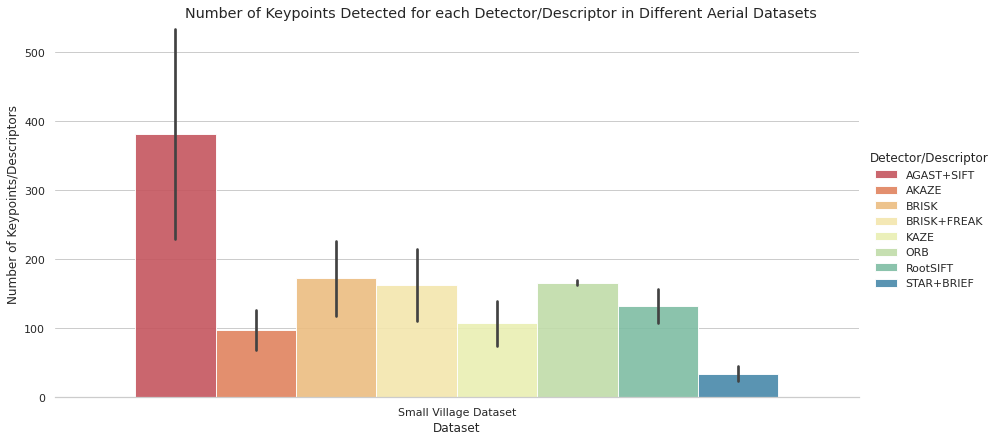

In [144]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_8, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [145]:
g.savefig(f'drive/MyDrive/Num_Kypoints_8_{Dataset}.png')

In [146]:
df_numkey_8.to_csv(f'drive/MyDrive/Num_Kypoints_8_{Dataset}.csv')

In [147]:
print(len(num_matches_agast))

119


Total Number of Matches Detected for each Detector+Descriptor

In [150]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_freak + num_matches_kaze + num_matches_orb + num_matches_rootsift + num_matches_briefstar, 'Detector/Descriptor':['AGAST+SIFT']*(len_files-1) + ['AKAZE']*(len_files-1) + ['BRISK']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['KAZE']*(len_files-1) + ['ORB']*(len_files-1) +['RootSIFT']*(len_files-1)  + ['STAR+BRIEF']*(len_files-1)  }
df_match_8 = pd.DataFrame(data=d)
df_match_8['Number of Total Matches'] = df_match_8['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

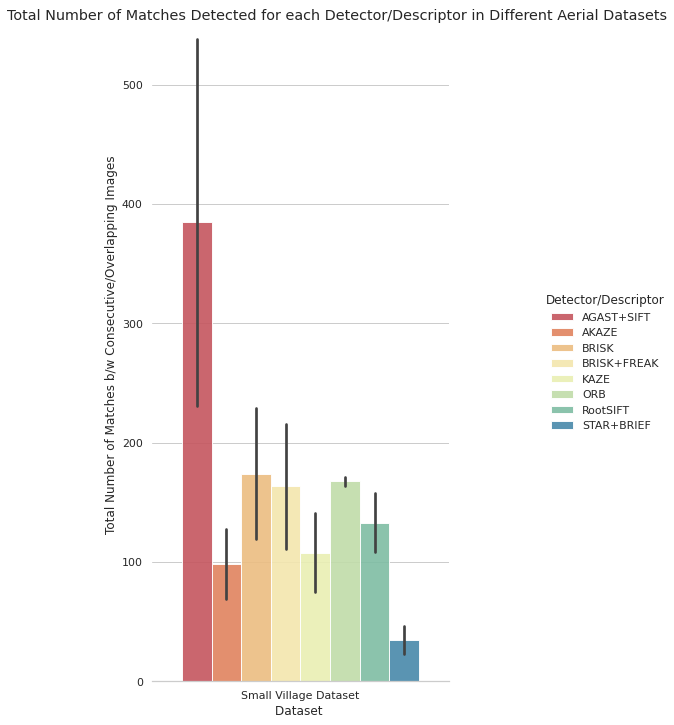

In [151]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_8, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [152]:
g.savefig(f'drive/MyDrive/Num_Matches_8_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [153]:
df_match_8['Number of Good Matches'] = num_good_matches_agast + num_good_matches_akaze + num_good_matches_brisk + num_good_matches_freak + num_good_matches_kaze + num_good_matches_orb + num_good_matches_rootsift + num_good_matches_briefstar
df_match_8['Number of Good Matches'] = df_match_8['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

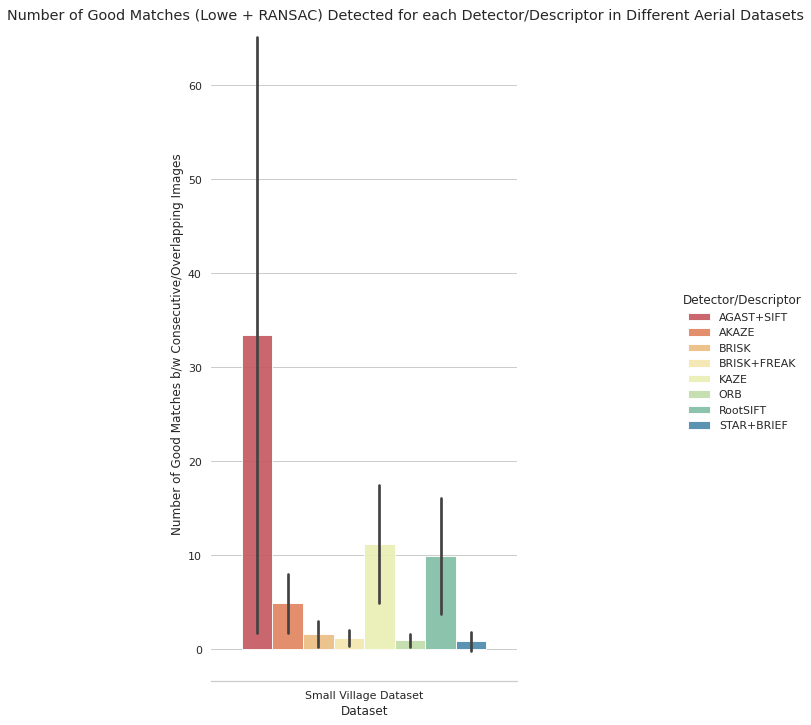

In [154]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_8, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [155]:
g.savefig('drive/MyDrive/Num_Good_Matches_8.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [156]:
df_match_8['Recall Rate of Matches'] = df_match_8['Number of Good Matches']/df_match_8['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

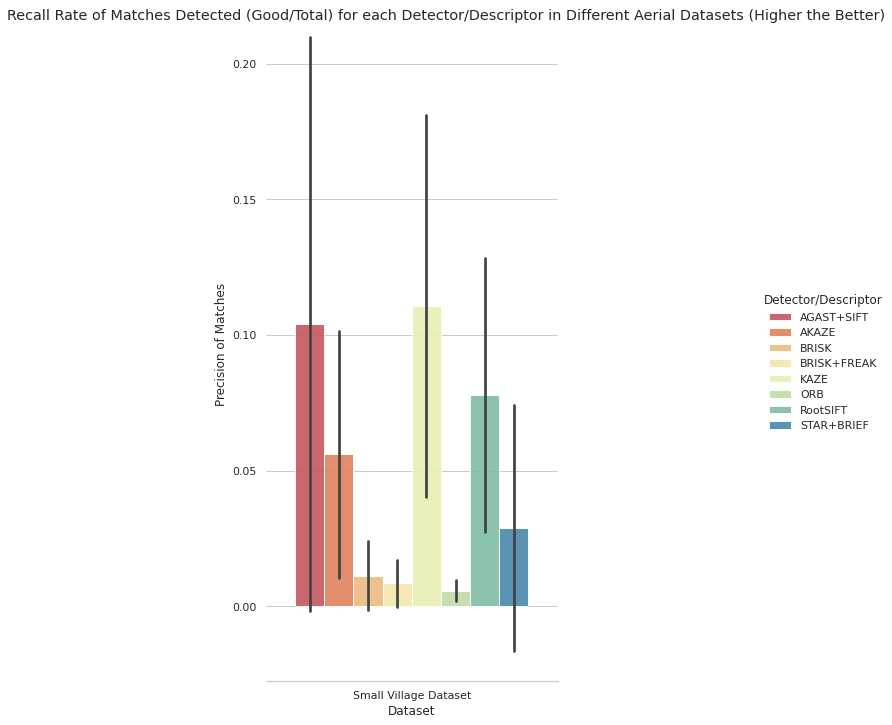

In [157]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_8, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [158]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_8.png')

1-Precision Rate for each Detector+Descriptor

In [159]:
df_match_8['1 - Precision Rate of Matches'] = (df_match_8['Number of Total Matches'] - df_match_8['Number of Good Matches'])/df_match_8['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

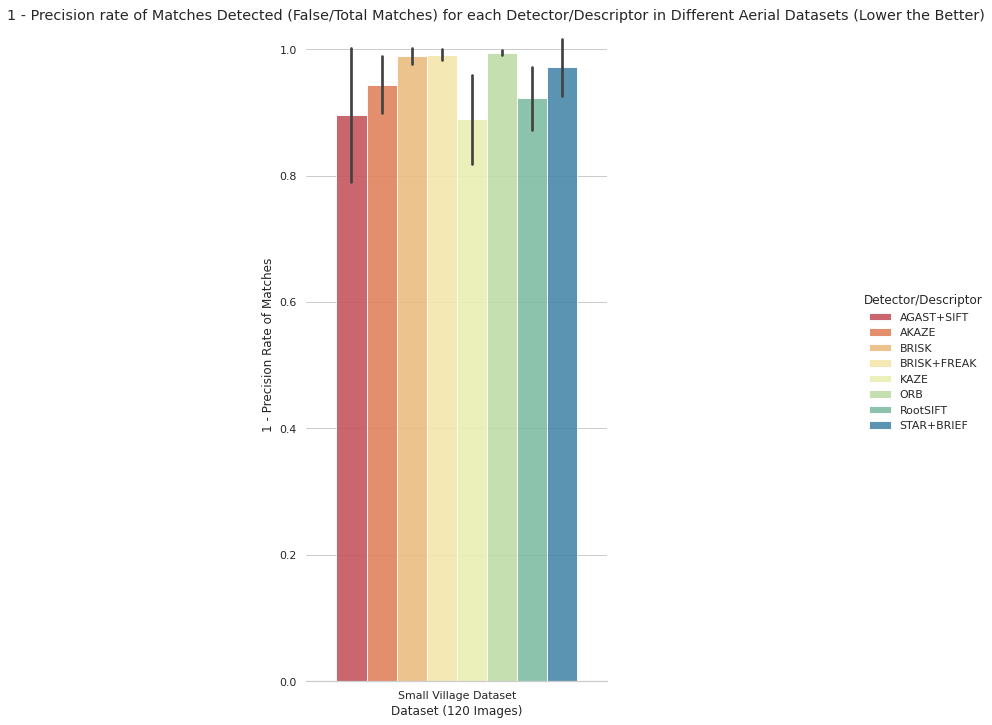

In [160]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_8, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [161]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_8.png')

F-Score for each Detector+Descriptor

In [162]:
df_match_8['F-Score'] = (2* (1 - df_match_8['1 - Precision Rate of Matches']) * df_match_8['Recall Rate of Matches'])/((1 - df_match_8['1 - Precision Rate of Matches']) + df_match_8['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

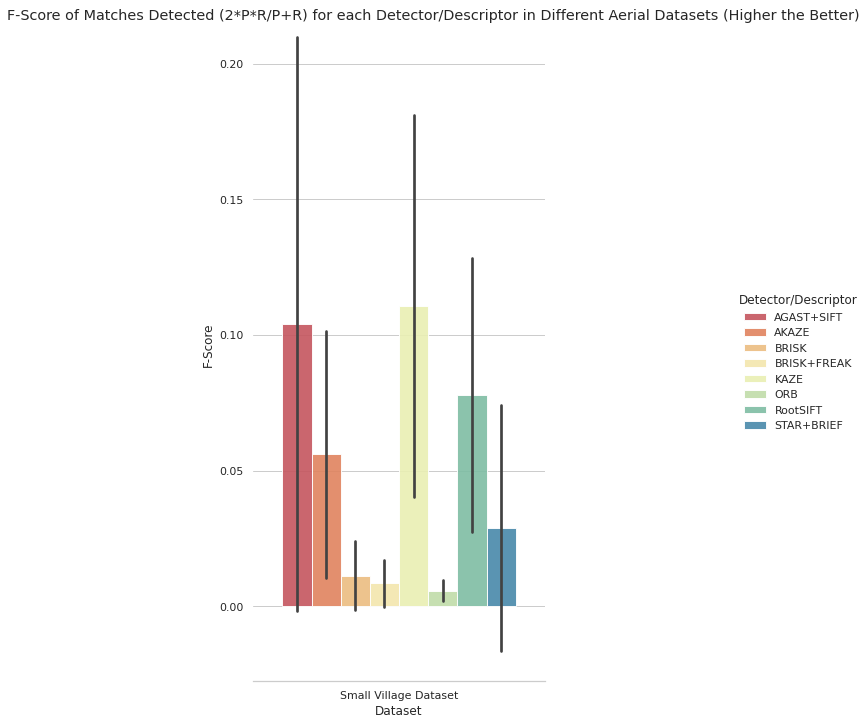

In [163]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_8, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [164]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_8.png')

In [165]:
df_match_8.to_csv('drive/MyDrive/All_metrics_8.csv')

Time for each Detector+Descriptor

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[7]] + [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[2]] + [time_all[6]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor':['AGAST+SIFT'] + ['AKAZE'] + ['BRISK']*(1) + ['BRISK+FREAK']*(1) + ['KAZE']*(1) +  ['ORB']*(1) +['RootSIFT']*(1) + ['STAR+BRIEF']*(1) }
df_time_8 = pd.DataFrame(data=d)

In [ ]:
print(df_time_8)

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_8, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_8.png')

In [ ]:
df_time_8.to_csv('drive/MyDrive/Time_8.csv')

Stitching with CPU